In [18]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold

from CrabNet_spacegroup.kingcrab import CrabNet
from CrabNet_spacegroup.model import Model
from CrabNet_spacegroup.get_compute_device import get_compute_device

from sklearn.metrics import mean_absolute_error as mae, \
                            r2_score as r2, \
                            mean_squared_error as mse

compute_device = get_compute_device()

In [19]:
from pymatgen.core import Composition

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
# 全局设置字体及大小，设置公式字体即可，若要修改刻度字体，可在此修改全局字体
config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['Times New Roman'],
    "font.size": 24,# 字号，大家自行调节
    'axes.unicode_minus': False # 处理负号，即-号
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300 #分辨率

In [20]:
df = pd.read_csv('./data/data.csv', index_col=0)
df['is_metal'] = df['target'].map(lambda x: 1 if x==0 else 0)
df['is_metal'].value_counts()

0    70216
1    64037
Name: is_metal, dtype: int64

In [21]:
df['index'] = df.index
spinels = pd.read_csv('./data/spinel_oxides.csv')
spinels = spinels[['formula_pretty','spacegroup_number','band_gap','is_gap_direct']]
spinels.columns = ['formula','spacegroup','GGA','is_gap_direct']
spinels['index'] = spinels.index
spinels = pd.merge(spinels,df , on=['formula','spacegroup'], how='inner')

In [22]:
df = df.drop(index=spinels['index_y'])
df = df.reset_index(drop=True)
spinels = spinels[['formula','spacegroup','GGA_x','target','is_gap_direct']]
spinels.columns = ['formula','spacegroup','GGA','target','is_gap_direct']

In [7]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_indices = kf.split(df["formula"], df["is_metal"])
for i, (train_index, val_index) in enumerate(cv_indices):
    train, val = df.loc[train_index], df.loc[val_index]
    name = f"fold_{i}"
    model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                      model_name=name, verbose=True, classification=False)
    if os.path.exists(f'./result/predictions_crabnet_spacegroup/{name}.csv'):
        res_df = pd.read_csv(f'./result/predictions_crabnet_spacegroup/{name}.csv')
        print(name)
        print(f"MAE: {mae(res_df['real'], res_df['pred'])}")
        print(f"R2: {r2(res_df['real'], res_df['pred'])}")
        print(f"RMSE: {np.sqrt(mse(res_df['real'], res_df['pred']))}")
    else:
        model.load_data(train, train=True)
        model.load_data(val)
        model.fit(epochs=1000, losscurve=True)
        res = model.best_results
        res_df = pd.DataFrame({"composition": res[2], "real": res[0], "pred": res[1], 'uncert':res[3]})
        print(name)
        print(f"MAE: {mae(res_df['real'], res_df['pred'])}")
        print(f"R2: {r2(res_df['real'], res_df['pred'])}")
        print(f"RMSE: {np.sqrt(mse(res_df['real'], res_df['pred']))}")
        res_df.to_csv(f'./result/predictions_crabnet_spacegroup/{name}.csv',index=False)
        model.save_network(f'{name}_spacegroup.pth')
    


Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cuda:0
Model size: 11992839 parameters

fold_0
MAE: 0.39155321827469797
R2: 0.829128412101926
RMSE: 0.8464993625004057

Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cuda:0
Model size: 11992839 parameters

fold_1
MAE: 0.40464160163956
R2: 0.8110039748497649
RMSE: 0.8876410590745158

Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cuda:0
Model size: 11992839 parameters

fold_2
MAE: 0.4003915230757205
R2: 0.816972611920566
RMSE: 0.8730075259415144

Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cuda:0
Model size: 11992839 parameters

fold_3
MAE: 0.39826848216112715
R2: 0.8169691642751864
RMSE: 0.8735916509089898

Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cuda:0
Model size: 11992839 parameters

fold_4
MAE: 0.3994935280485604
R2: 0.8227

In [28]:
model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                      verbose=True, classification=False)
best_mae = 1
best_fold = 0
for i in range(0,5):
    model.load_network(f'./models/trained_models/fold_{i}_spacegroup.pth')
    real = spinels['target']
    model.load_data(spinels)
    pred  = model.predict(model.data_loader)[1]
    print(f"MAE: {mae(real, pred)}")
    print(f"R2: {r2(real, pred)}")
    print(f"RMSE: {np.sqrt(mse(real, pred))}")
    tmp_mae = mae(real, pred)
    if tmp_mae < best_mae:
        best_mae = tmp_mae
        best_fold = i


Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cuda:0
Model size: 11992839 parameters



Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 170012.32formulae/s]

loading data with up to 3 elements in the formula
MAE: 0.5287497791010434
R2: 0.7517891799501886
RMSE: 0.9048505751576693



Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 169769.45formulae/s]


loading data with up to 3 elements in the formula
MAE: 0.4663104239521961
R2: 0.8064515656630413
RMSE: 0.7990267948580462


Generating EDM: 100%|██████████| 170/170 [00:00<?, ?formulae/s]


loading data with up to 3 elements in the formula
MAE: 0.5017127051883054
R2: 0.7761740791293844
RMSE: 0.8592542760202088


Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 169971.79formulae/s]


loading data with up to 3 elements in the formula
MAE: 0.4809119440078557
R2: 0.7822546438993806
RMSE: 0.8475024509059365


Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 169971.79formulae/s]

loading data with up to 3 elements in the formula
MAE: 0.5051375721126847
R2: 0.778435794796972
RMSE: 0.8549019579313444


Generating EDM: 100%|██████████| 64/64 [00:00<?, ?formulae/s]


loading data with up to 3 elements in the formula


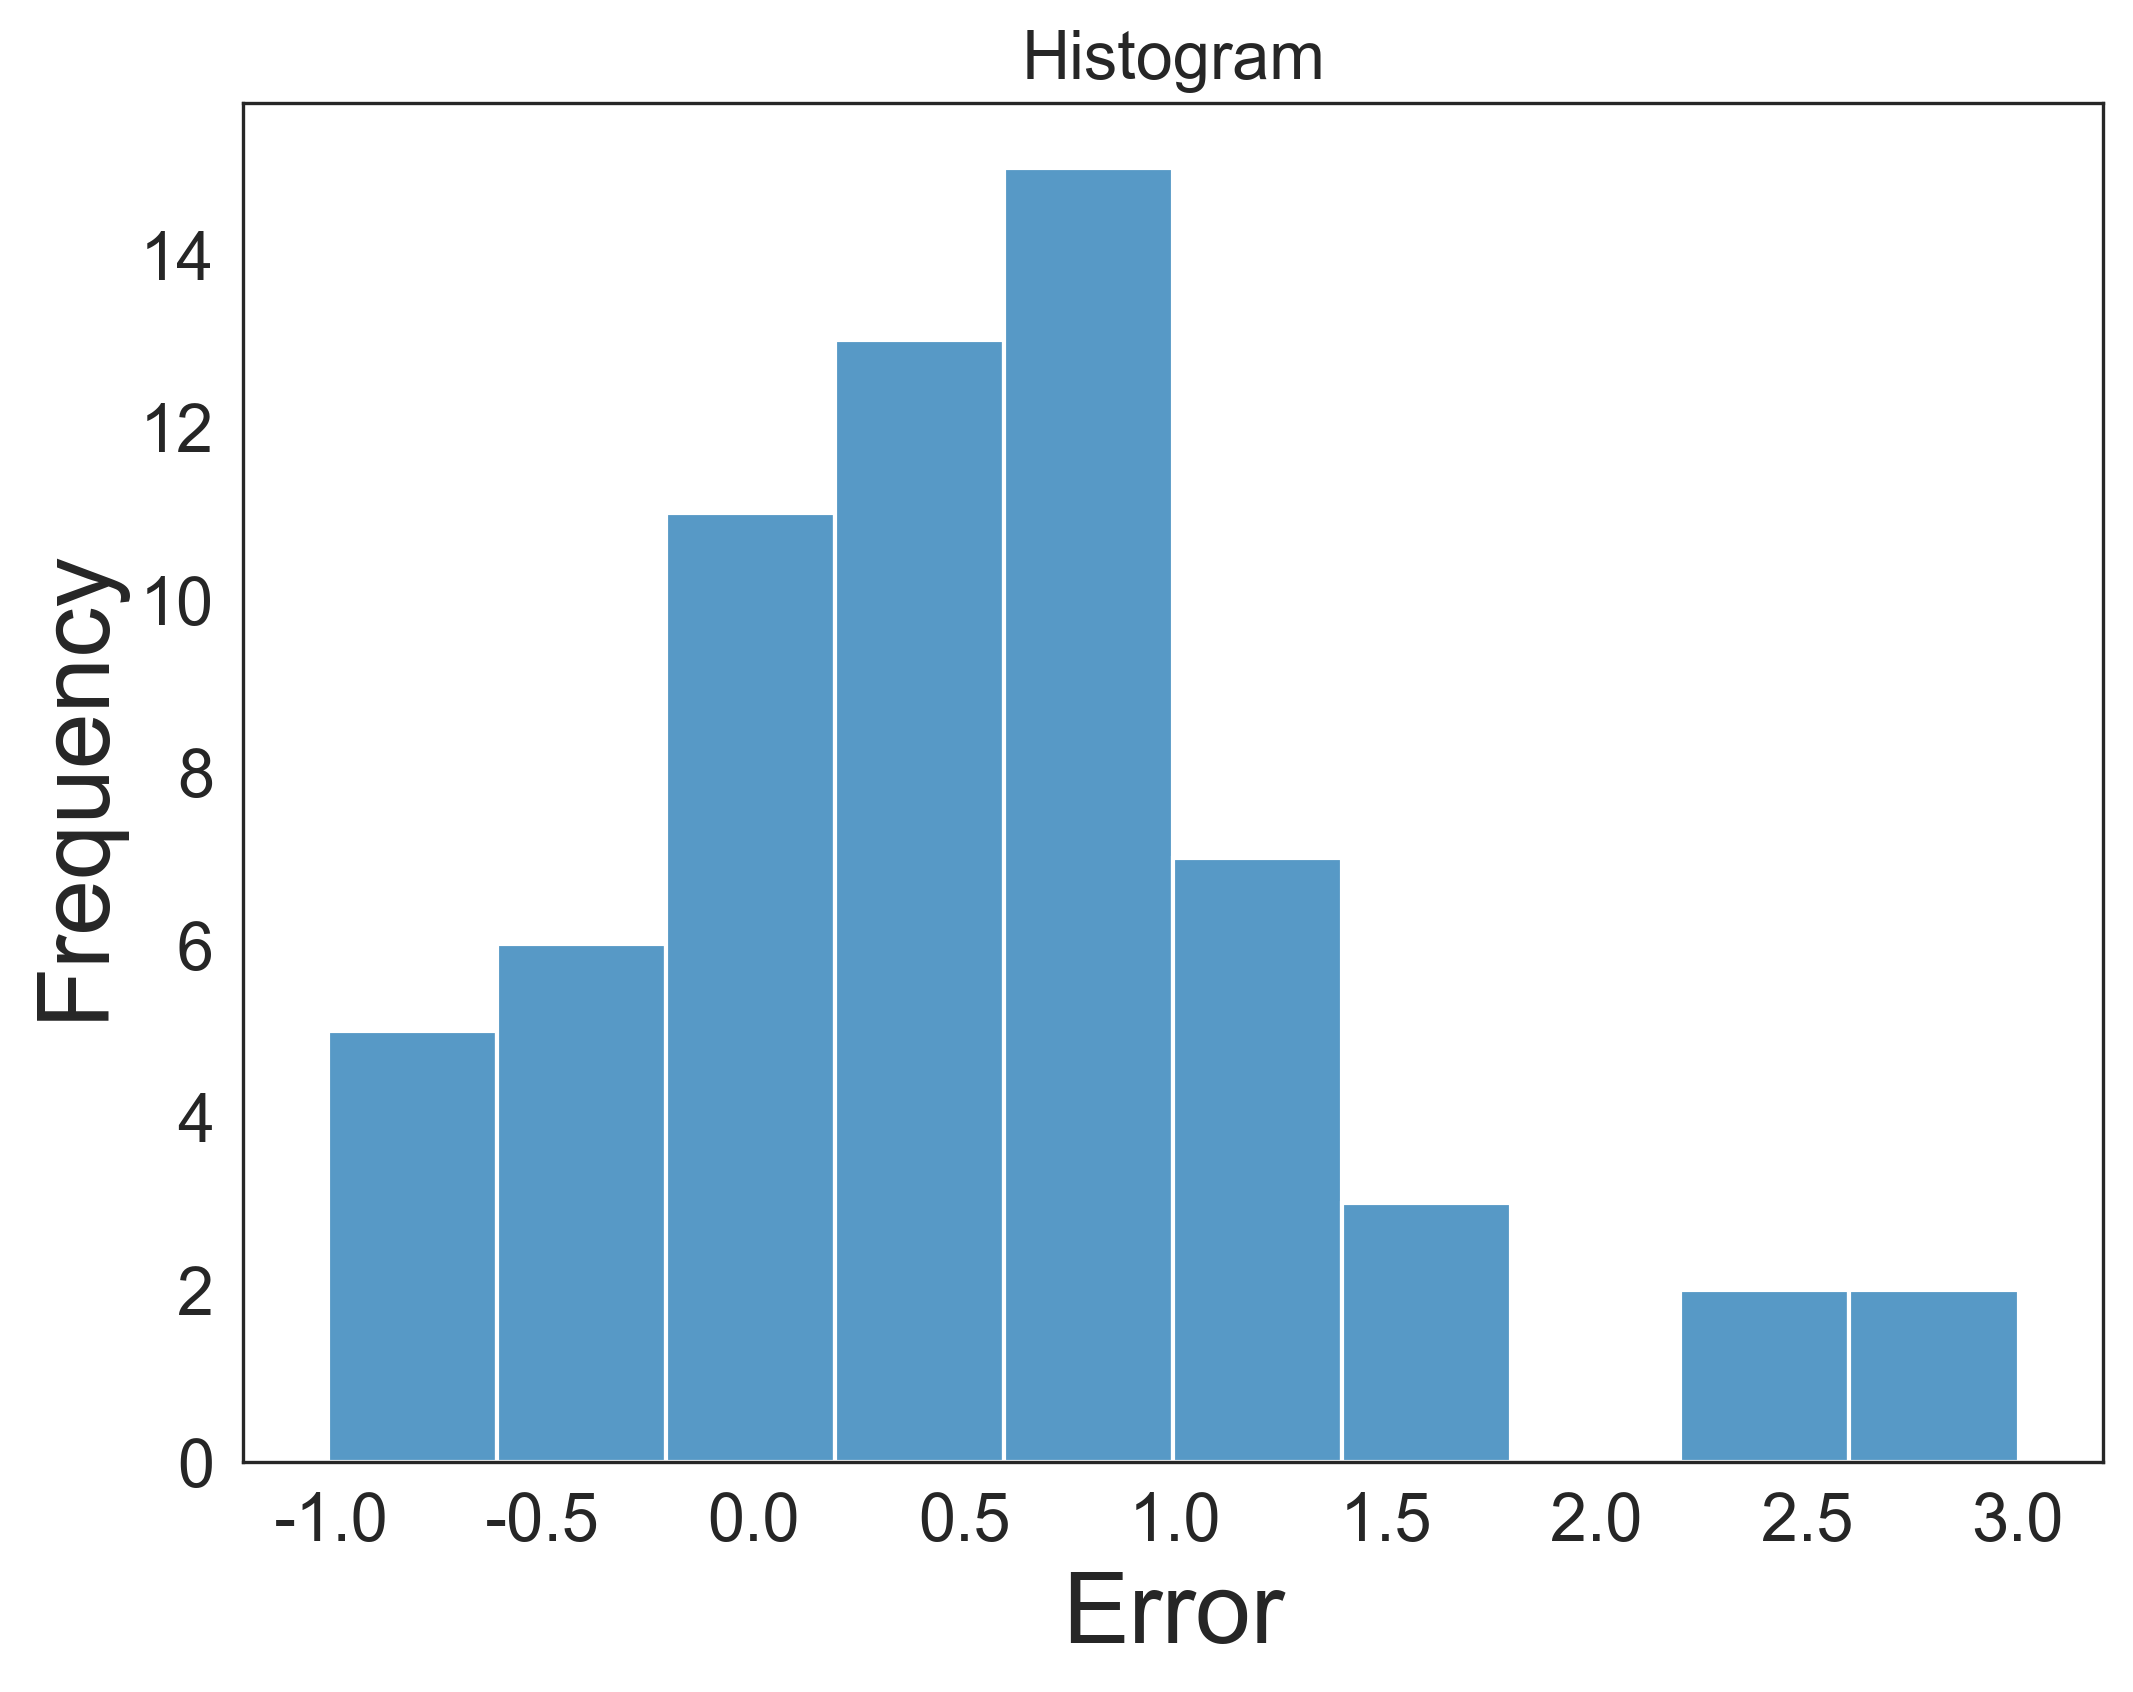

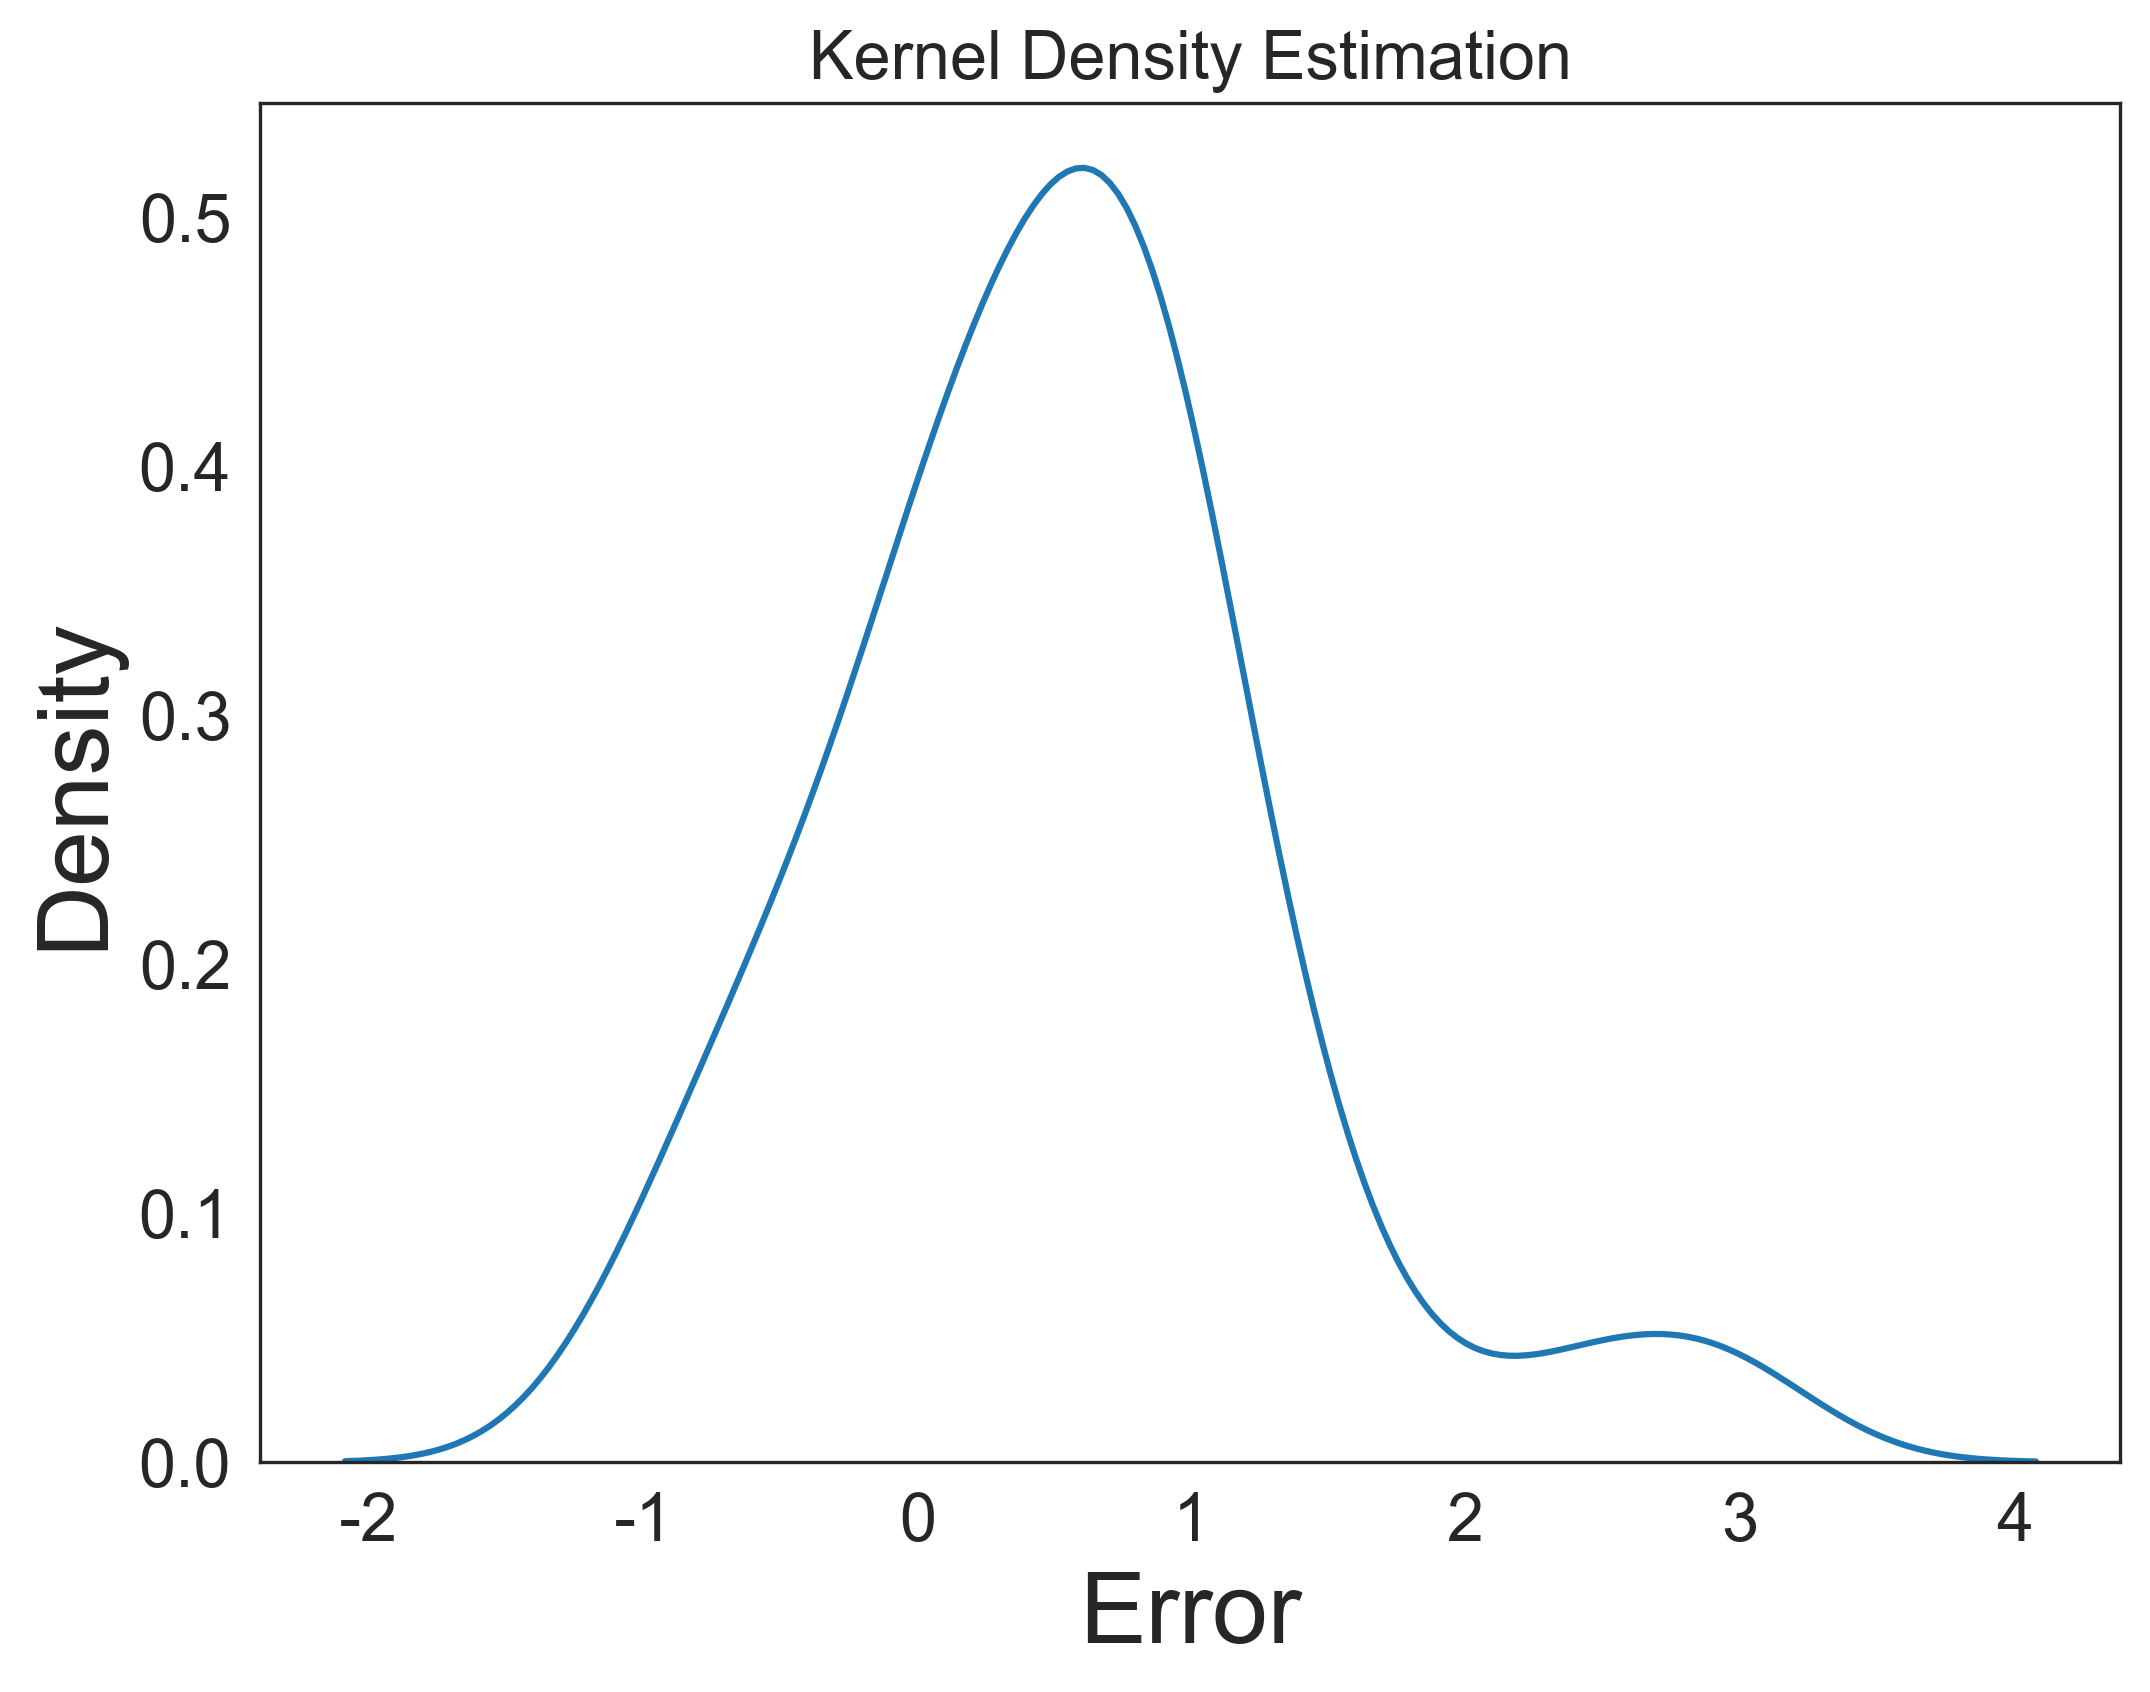

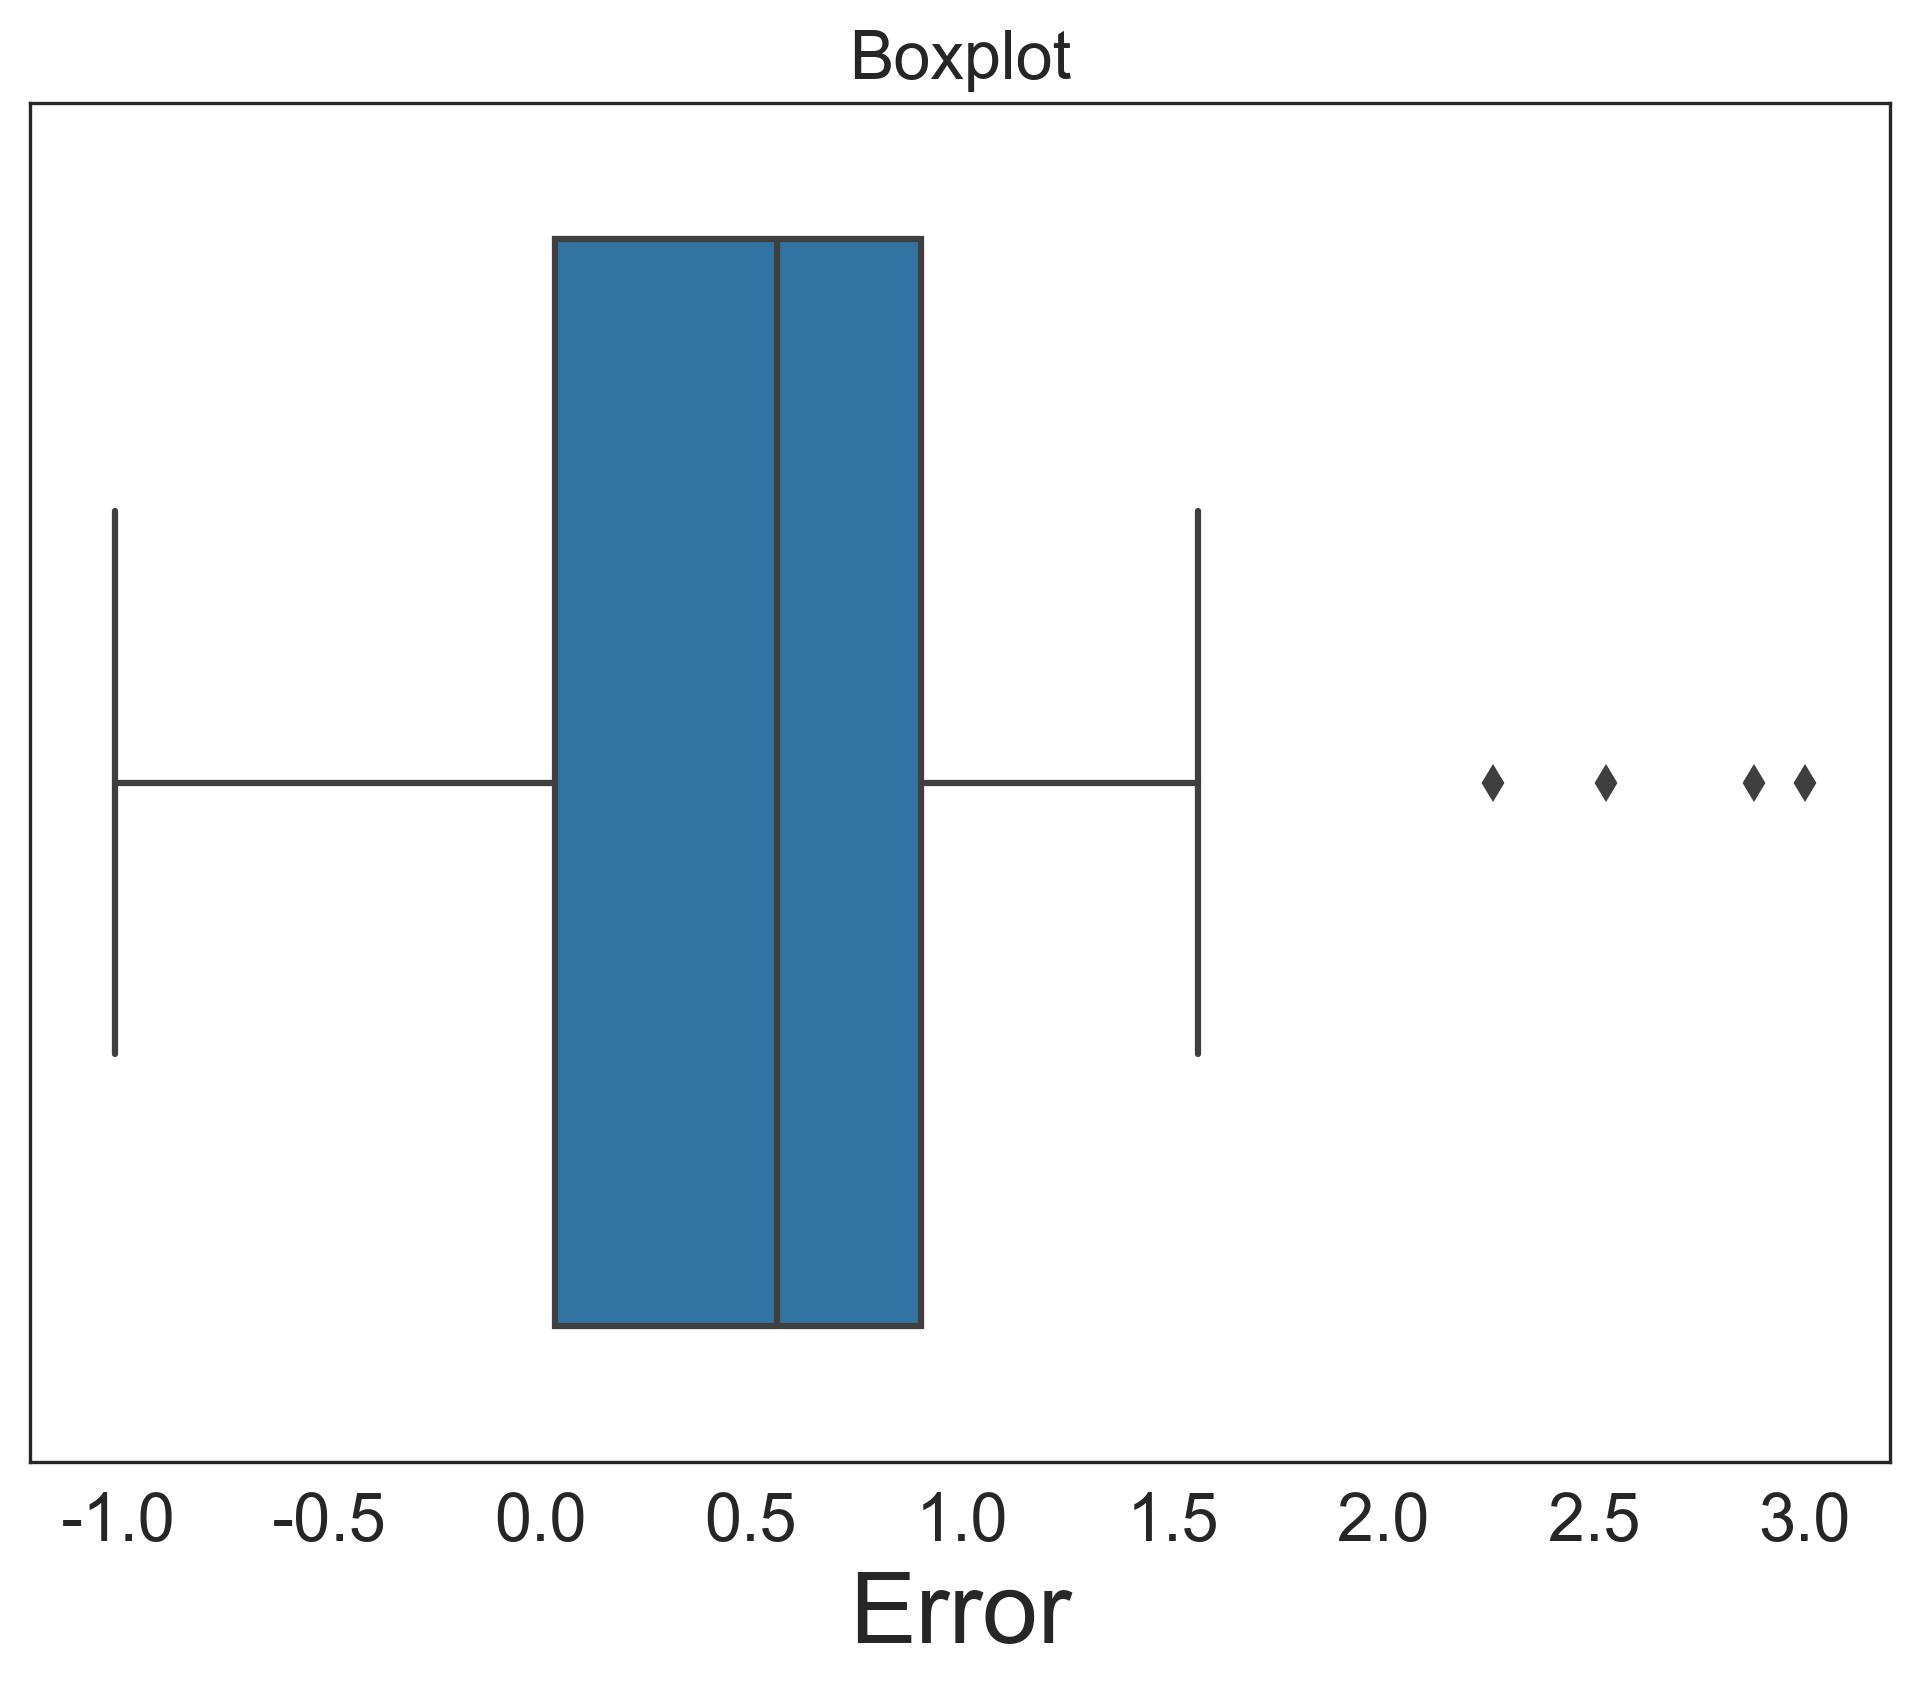

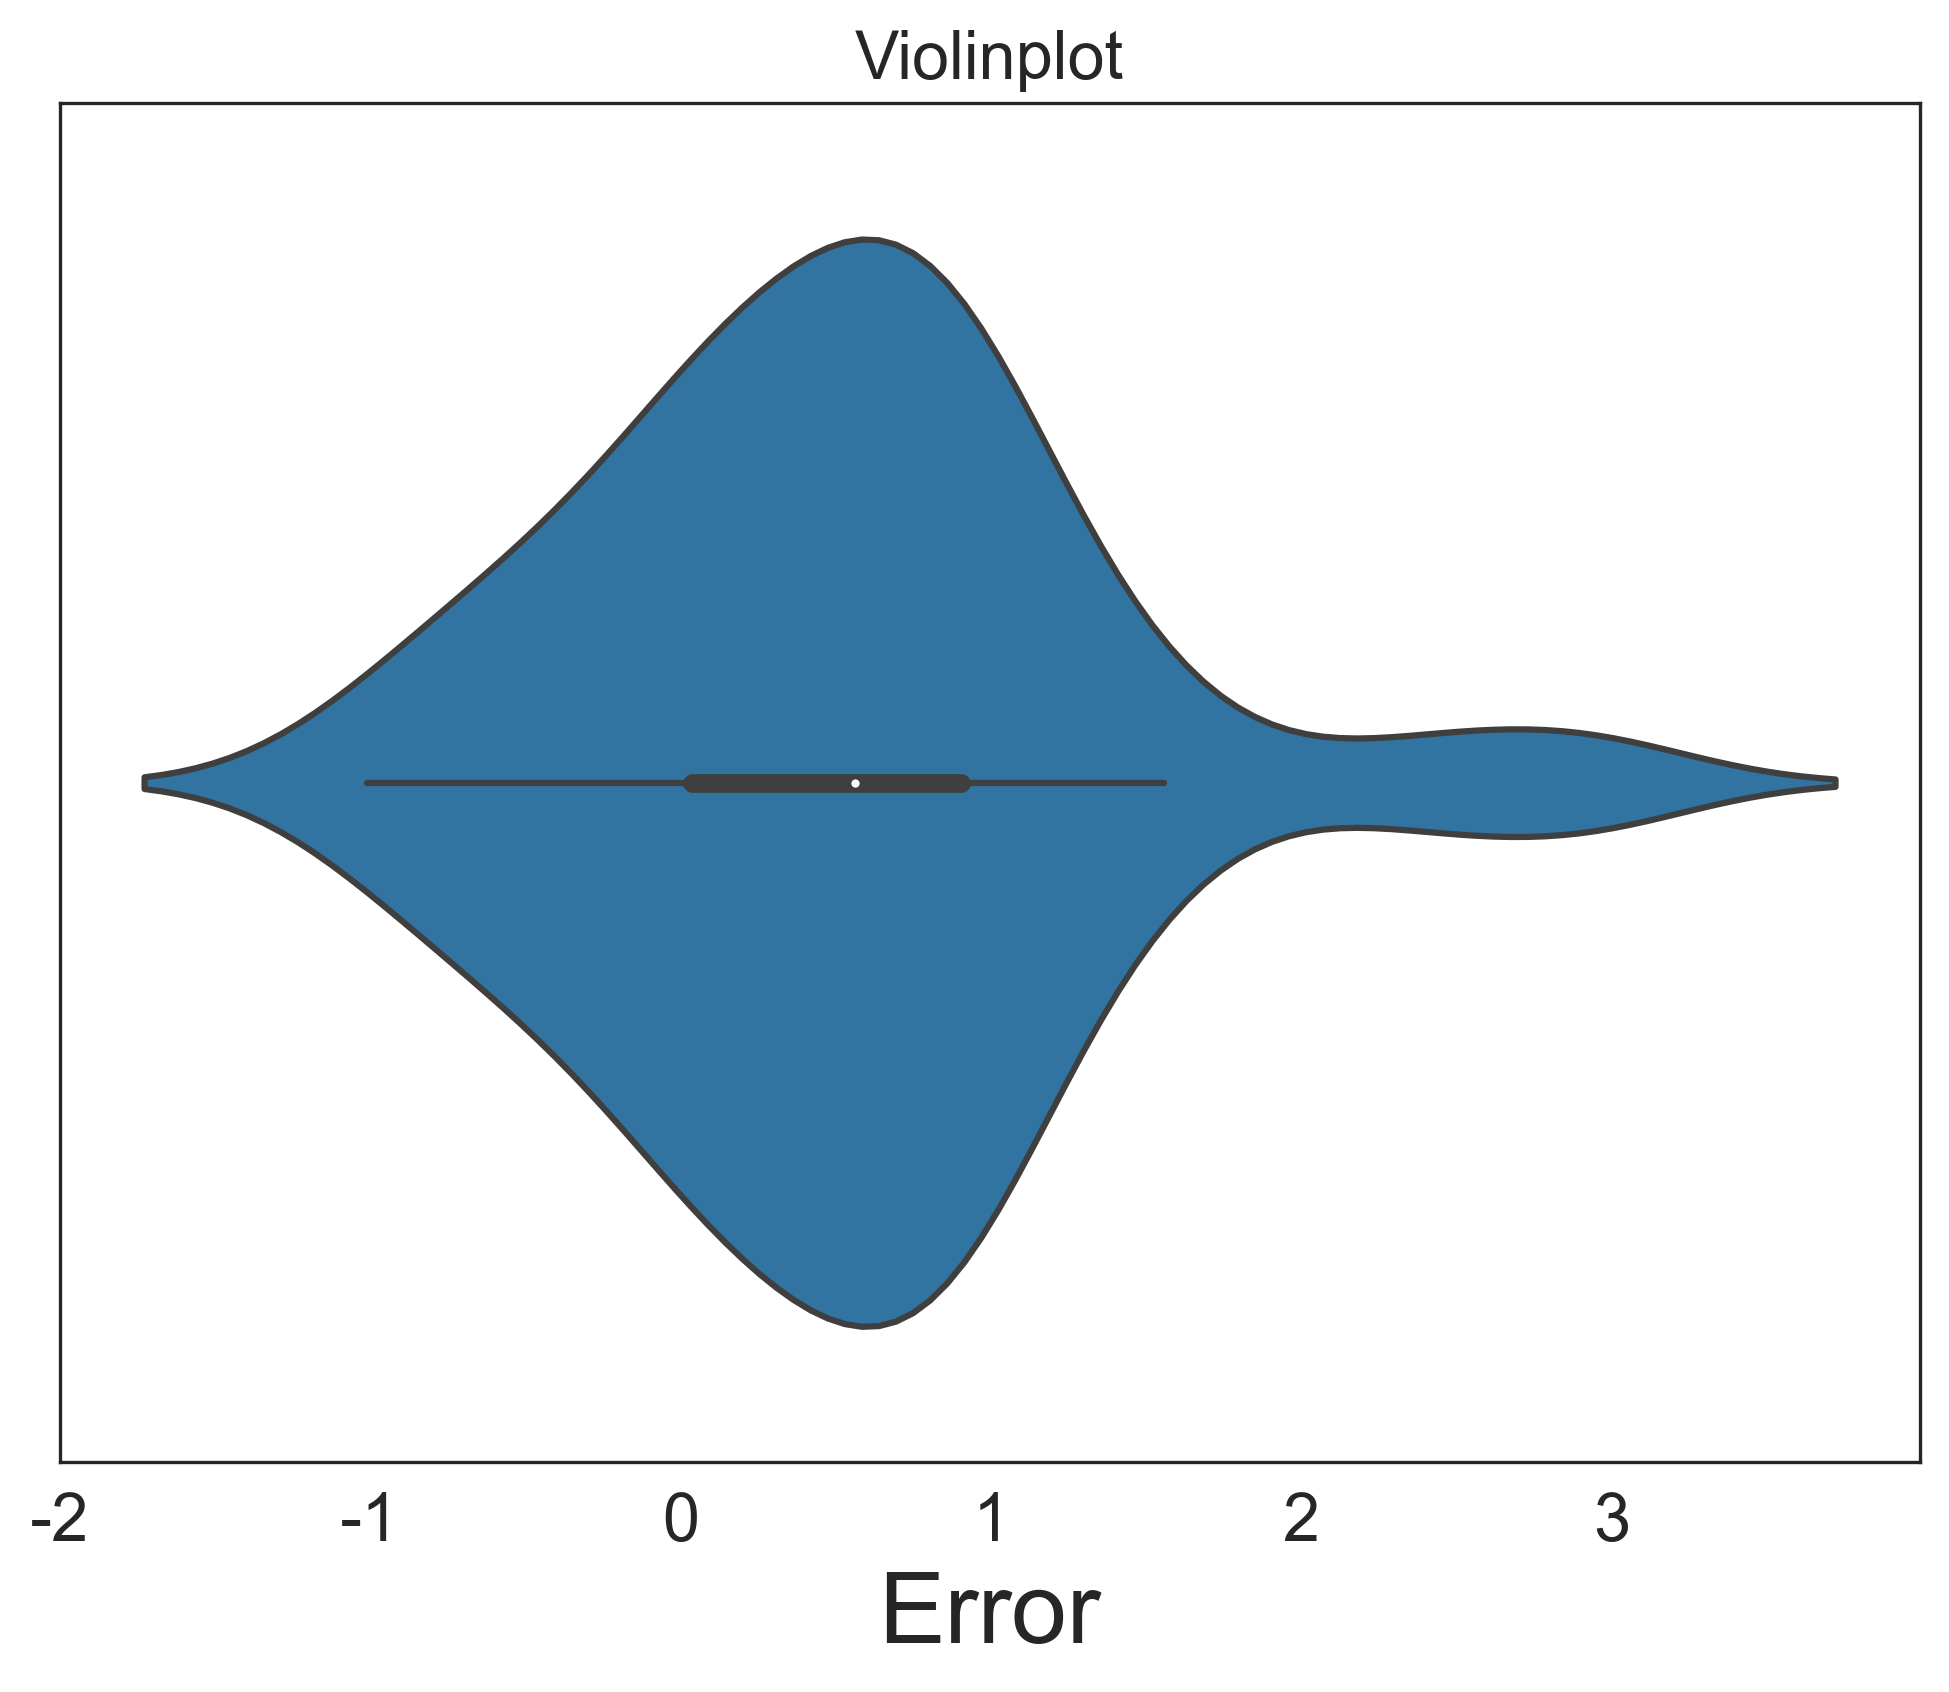

In [48]:
# Plot the distribution of real values and predicted values
plt.figure(figsize=(8, 6),facecolor='white')
sns.set_style('white')
model.load_network(f'./models/trained_models/fold_{best_fold}_spacegroup.pth')
spinels = spinels[spinels['target']!=spinels['GGA']]
real = spinels['target']
model.load_data(spinels)
pred  = model.predict(model.data_loader)[1]
error = real - pred
# Histogram
sns.histplot(error)
plt.title('Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Kernel Density Estimation
sns.kdeplot(error)
plt.title('Kernel Density Estimation')
plt.xlabel('Error')
plt.ylabel('Density')
plt.show()

# Boxplot
sns.boxplot(error)
plt.title('Boxplot')
plt.xlabel('Error')
plt.show()

# Violinplot
sns.violinplot(error)
plt.title('Violinplot')
plt.xlabel('Error')
plt.show()

In [39]:
pd.DataFrame(np.abs(error)).describe()

,target
count,170.000000
mean,0.466310
std,0.650761
min,0.000010
25%,0.000586
50%,0.092206
75%,0.745090
max,3.001668


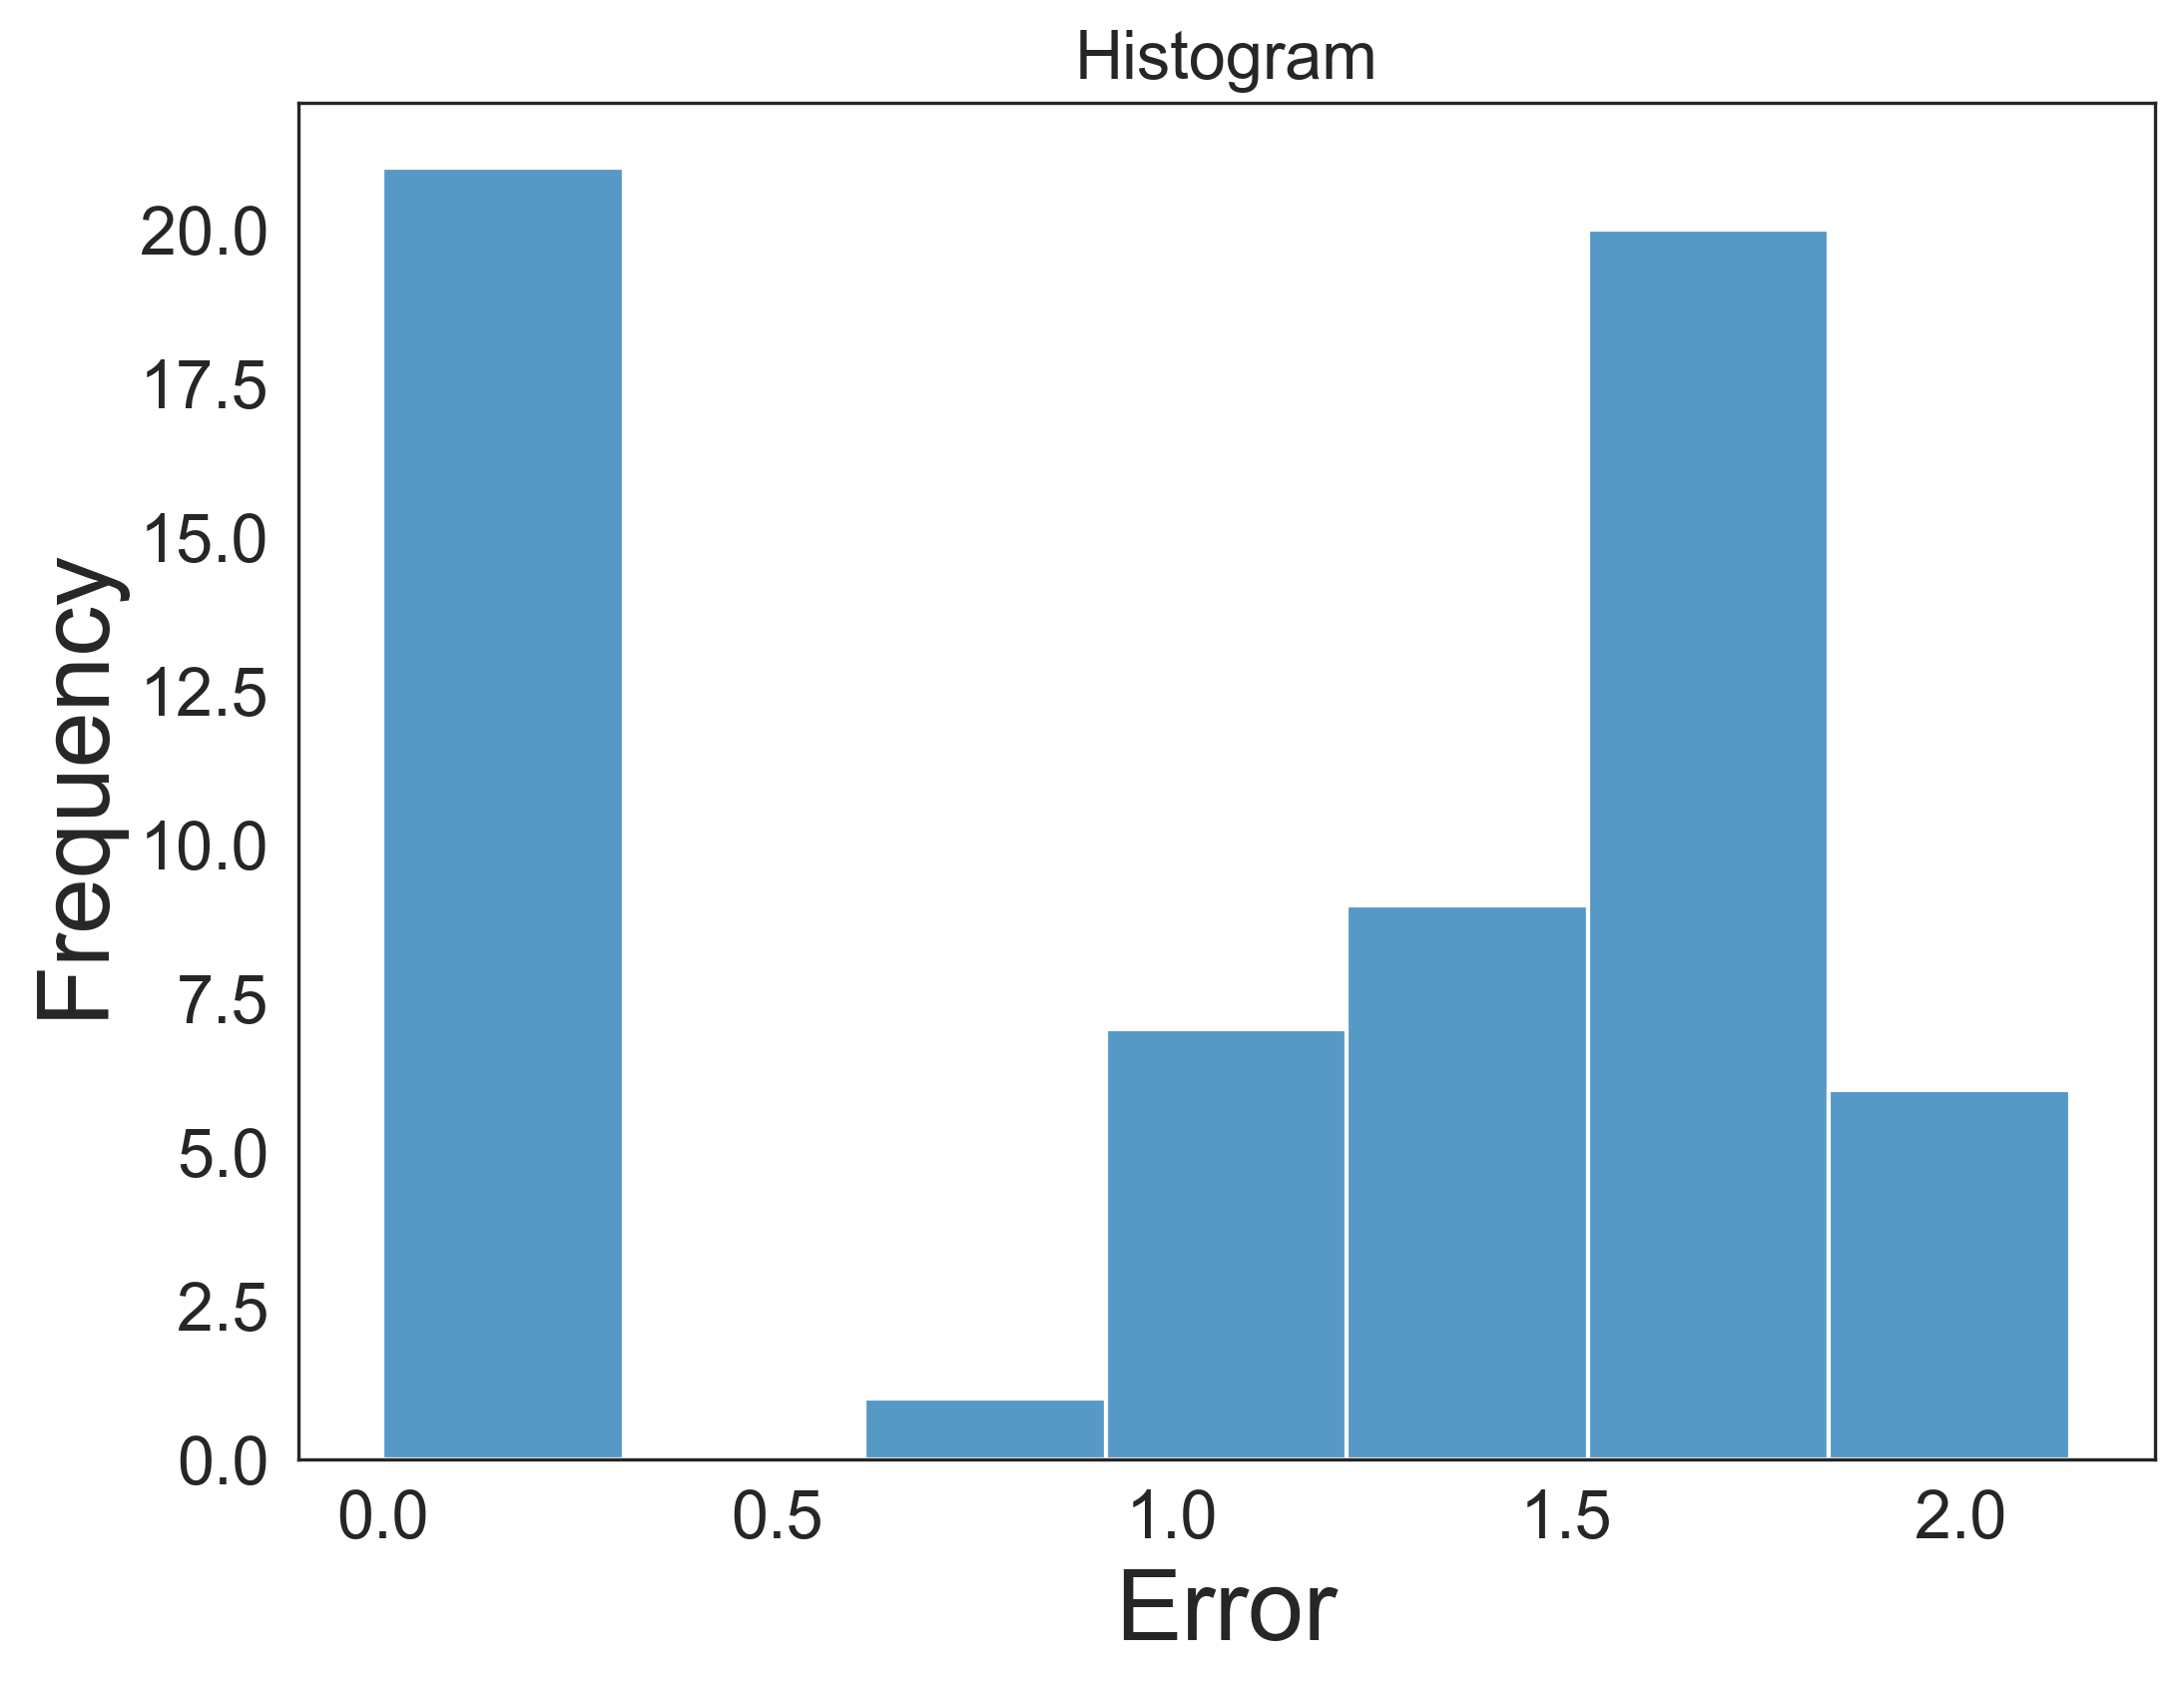

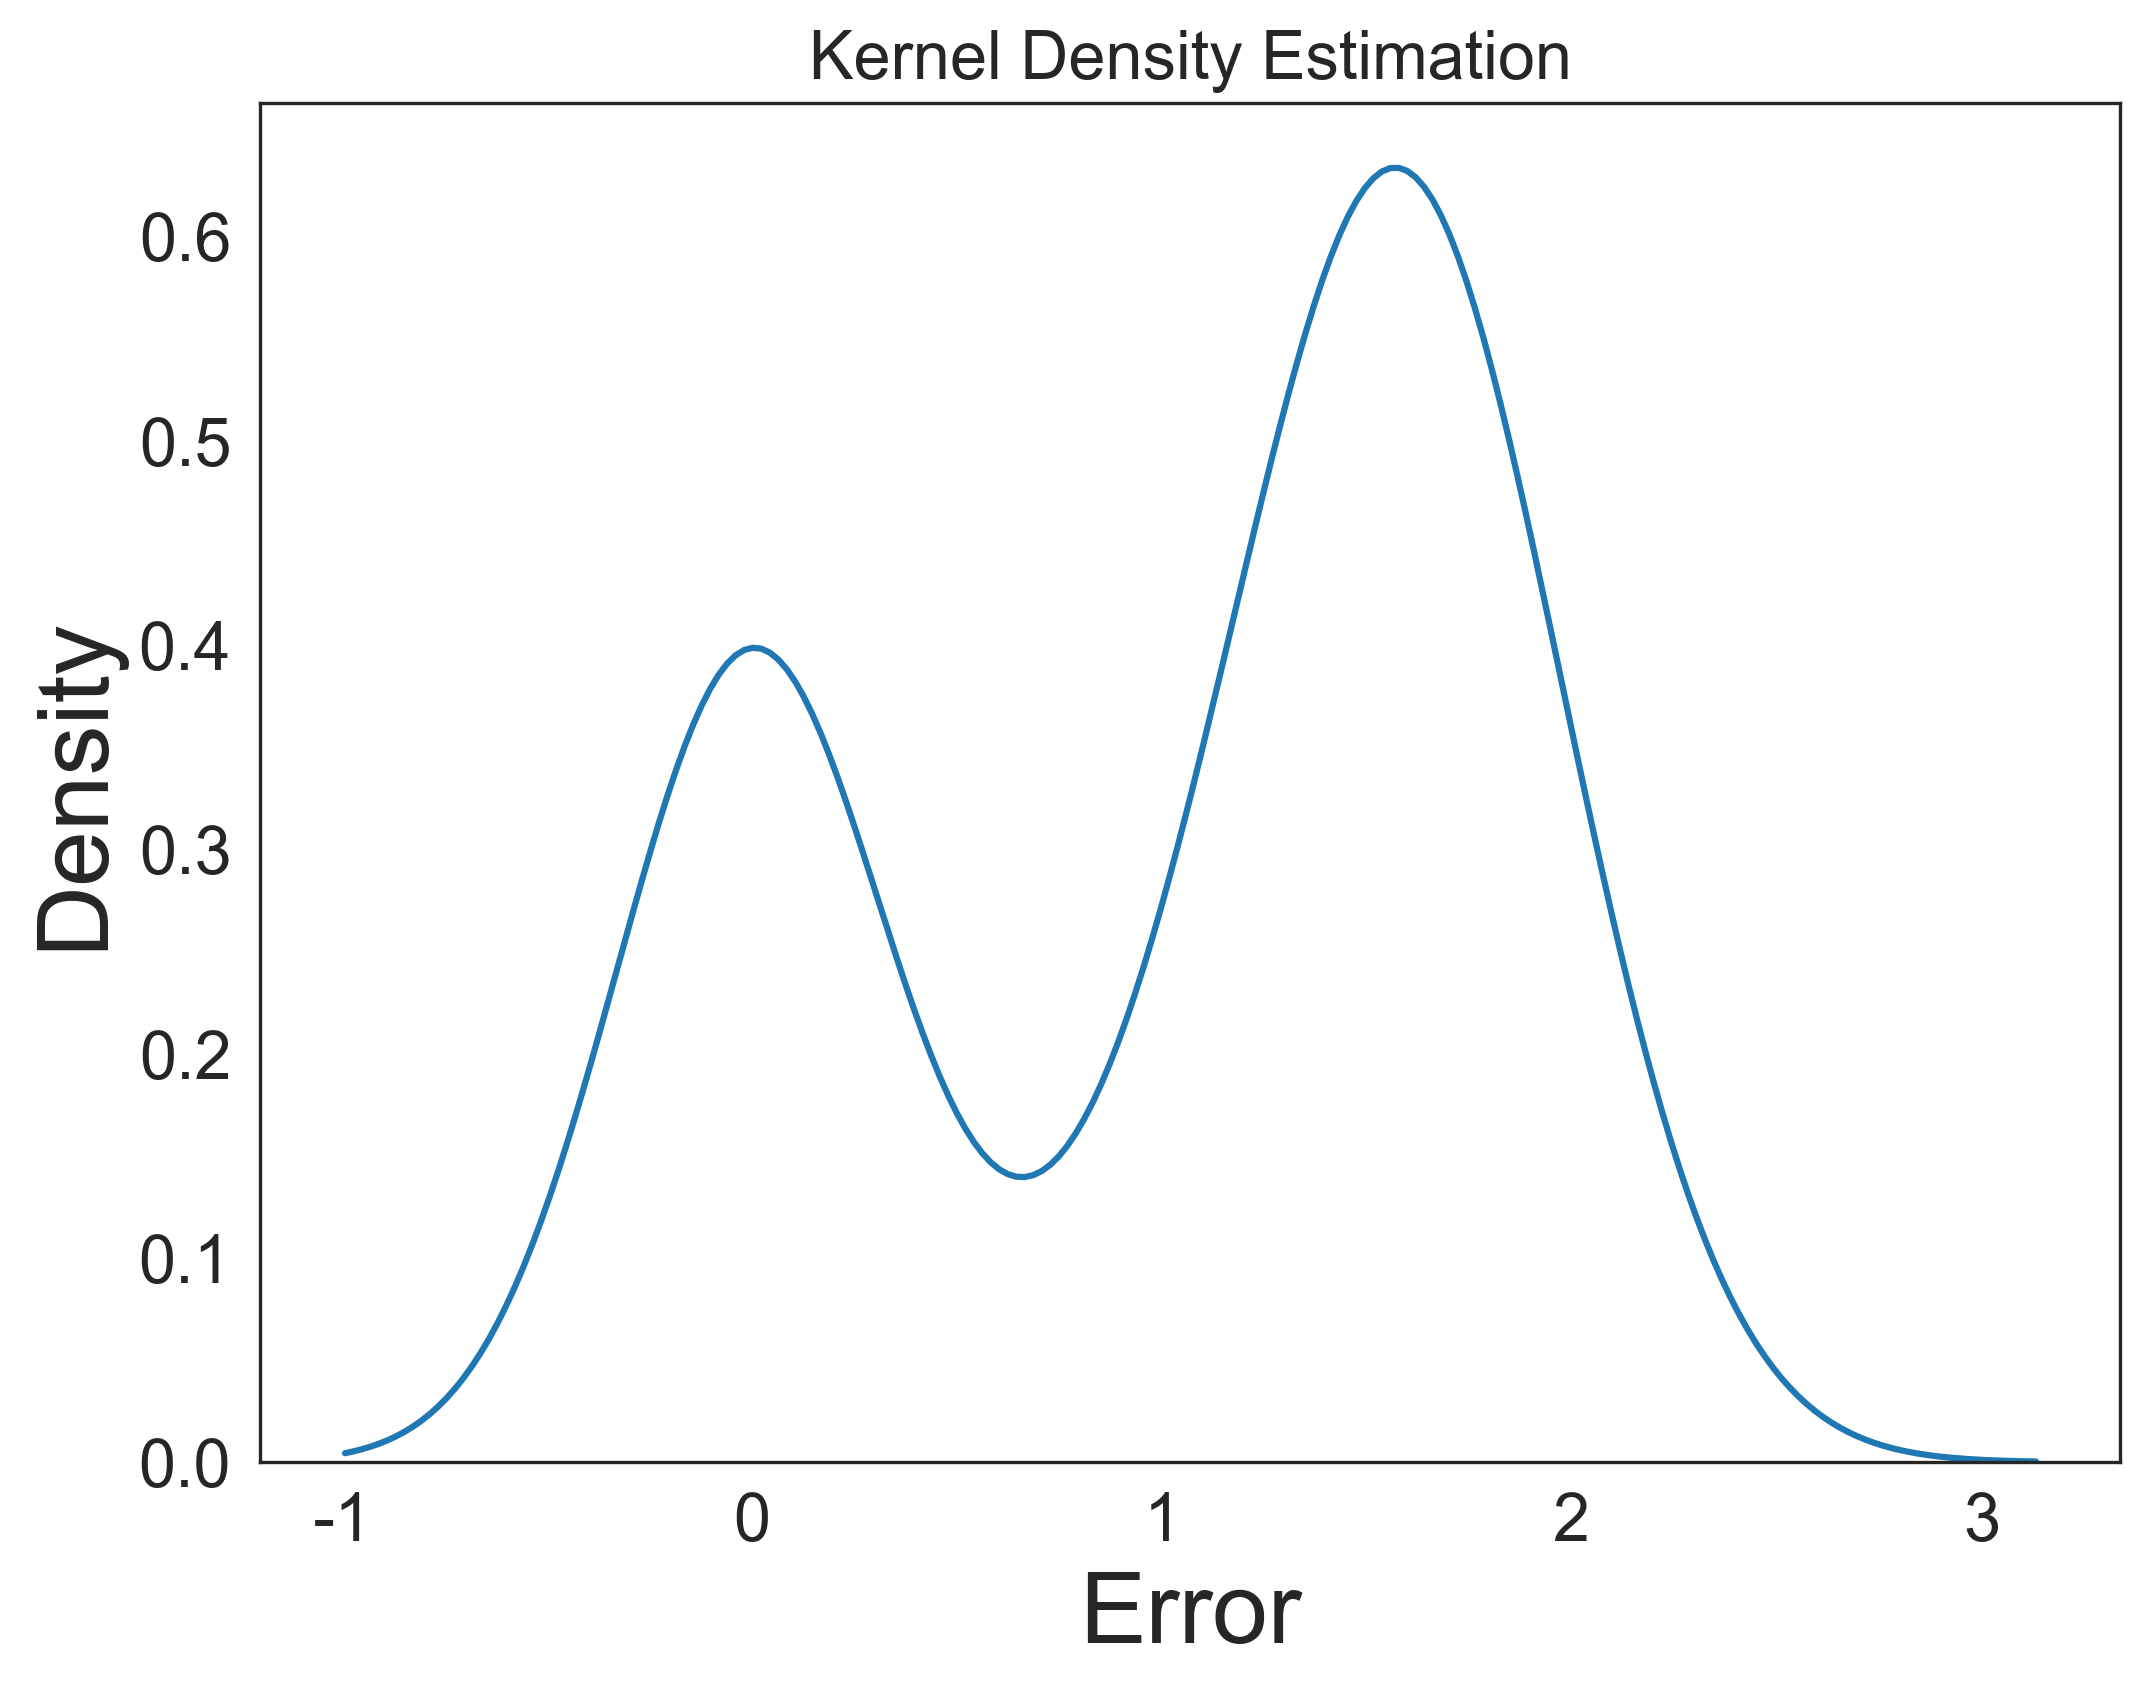

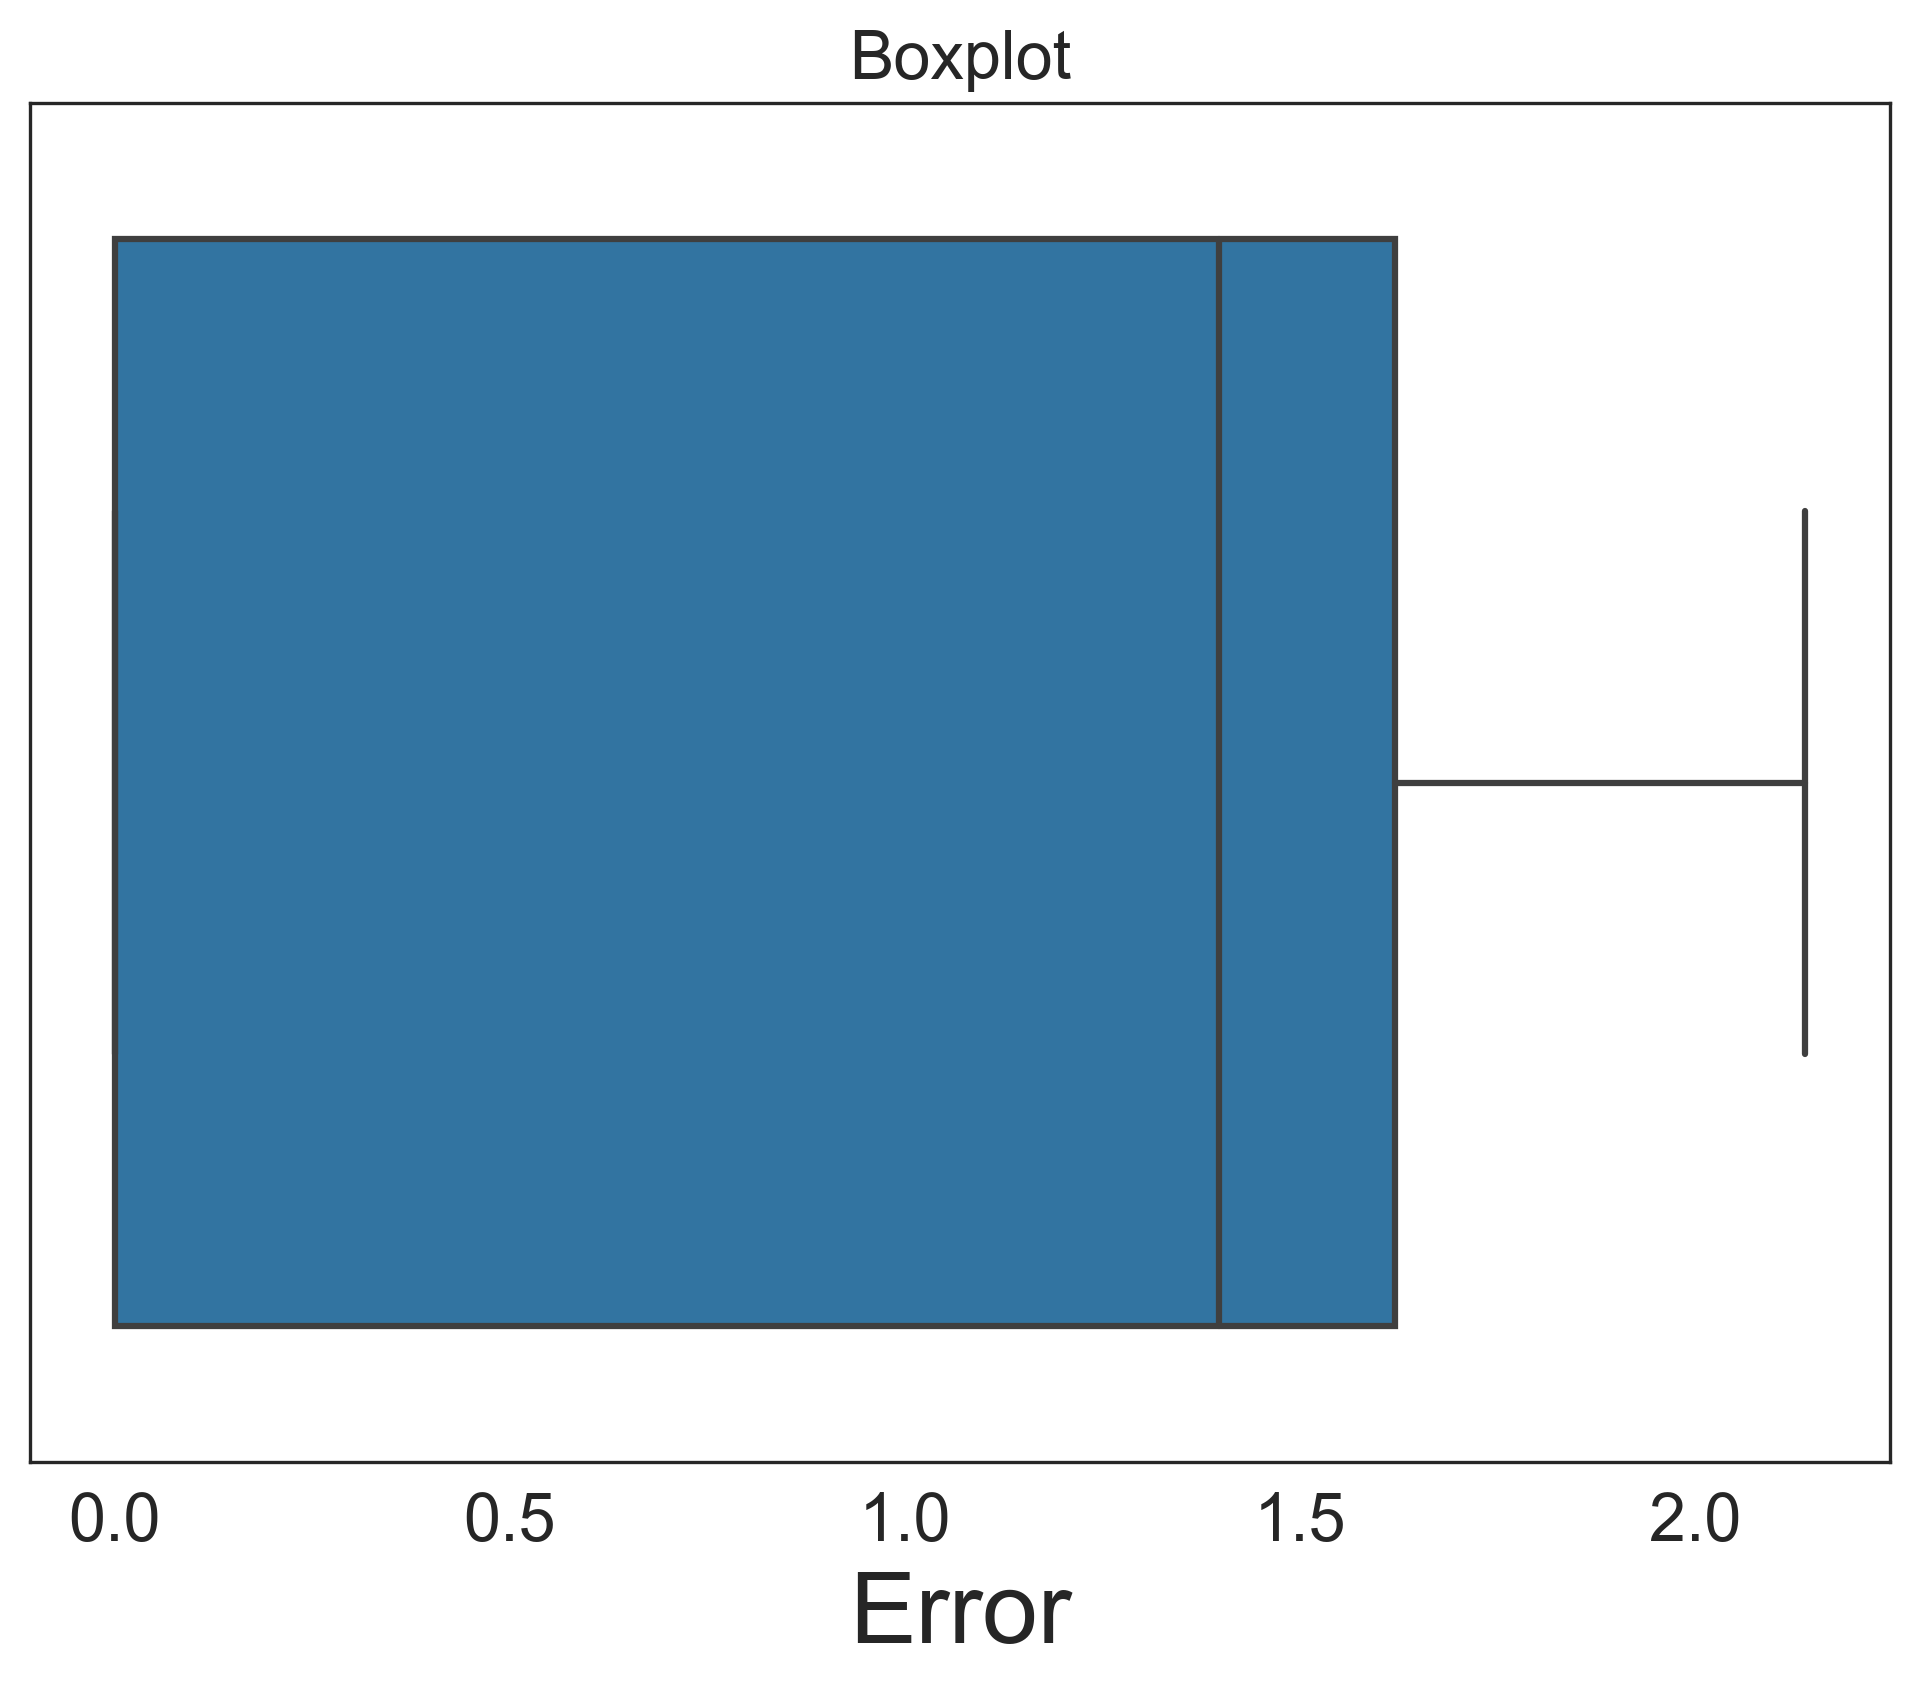

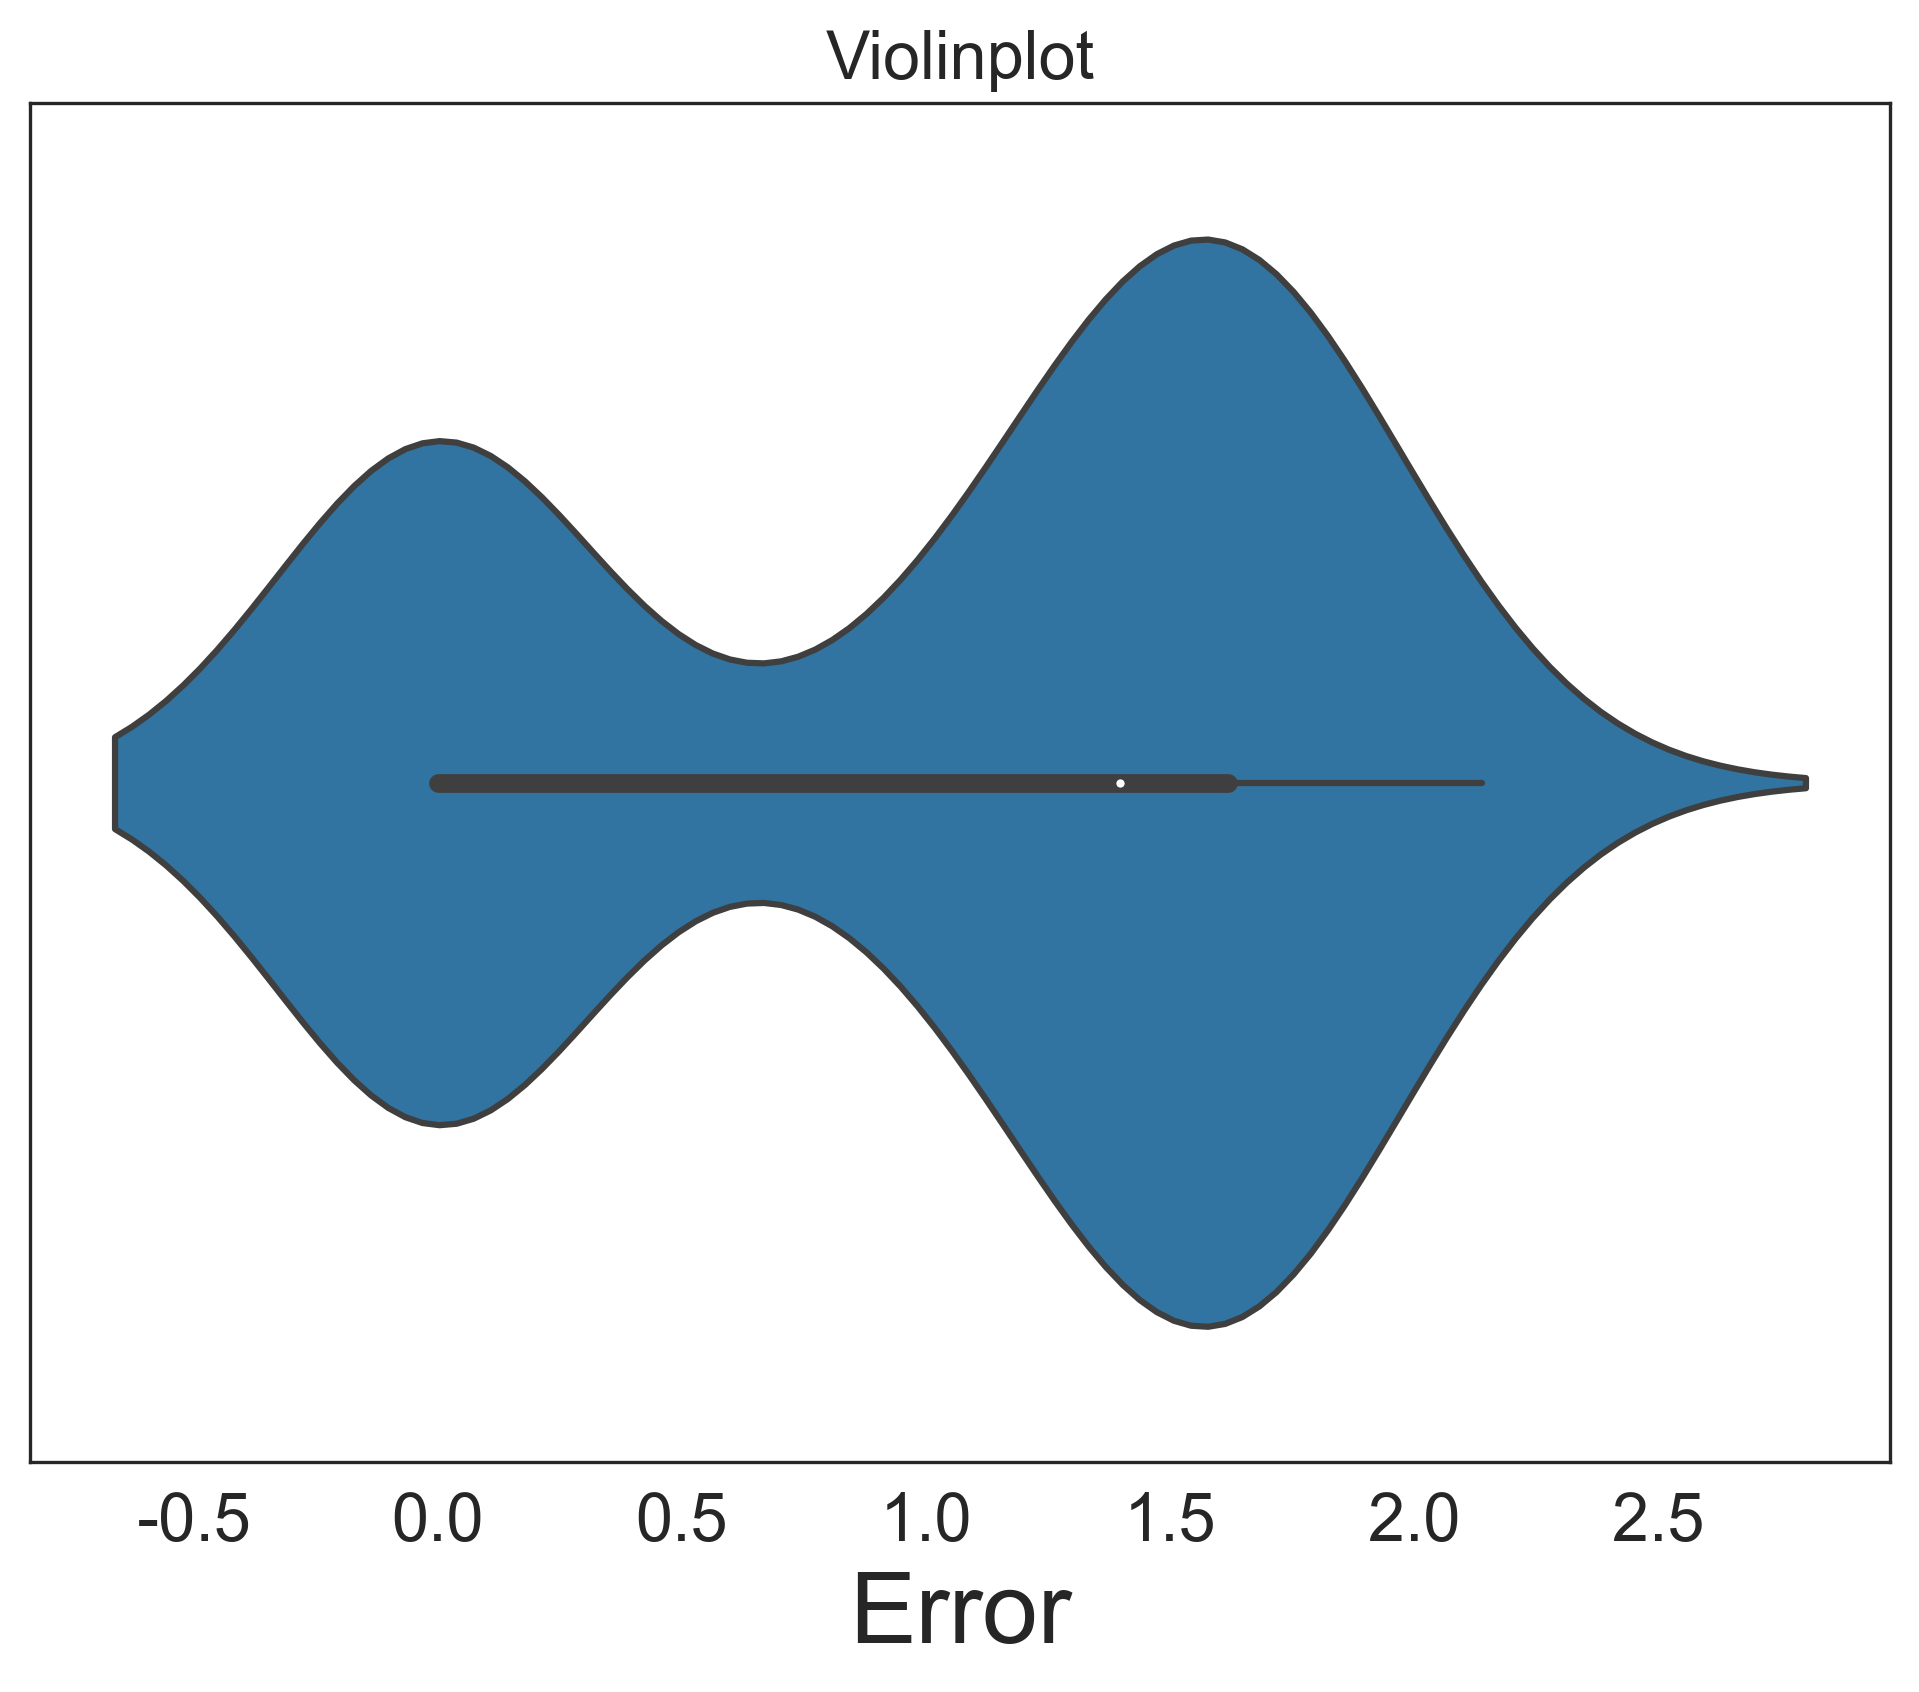

In [43]:
spinels_gga = spinels[spinels['GGA']!=spinels['target']]
real = spinels_gga['target']
gga = spinels_gga['GGA']
error = real - gga
# Histogram
sns.histplot(error)
plt.title('Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Kernel Density Estimation
sns.kdeplot(error)
plt.title('Kernel Density Estimation')
plt.xlabel('Error')
plt.ylabel('Density')
plt.show()

# Boxplot
sns.boxplot(error)
plt.title('Boxplot')
plt.xlabel('Error')
plt.show()

# Violinplot
sns.violinplot(error)
plt.title('Violinplot')
plt.xlabel('Error')
plt.show()

In [45]:
pd.DataFrame(np.abs(error)).describe()

,0
count,6.400000e+01
mean,1.028617e+00
std,7.607468e-01
min,1.040834e-16
25%,4.440892e-16
50%,1.397448e+00
75%,1.619306e+00
max,2.139132e+00


In [46]:
print(spinels_gga.shape)

(64, 6)


# Predicting new data band gaps

In [53]:
data = pd.read_csv('./data/cation_replacement_features.csv',index_col=0)
data['spacegroup'] = 227
data

,A_Density,B_Density,A_dipole Polarizability,B_dipole Polarizability,A_covalent Radius,B_covalent Radius,A_atomic Radius,B_atomic Radius,A_FirstIonization,B_FirstIonization,A_number of Valence Electrons,B_number of Valence Electrons,A_number,B_number,A_Period,B_Period,A_Electronegativity,B_Electronegativity,A_number of s+p Electrons,B_number of s+p Electrons,A_number of d Electrons,B_number of d Electrons,A_Mulliken EN,B_Mulliken EN,A-B_Density,(A+B)-O_Density,A-B_dipole Polarizability,(A+B)-O_dipole Polarizability,A-B_covalent Radius,(A+B)-O_covalent Radius,A-B_atomic Radius,(A+B)-O_atomic Radius,A-B_FirstIonization,(A+B)-O_FirstIonization,A-B_number of Valence Electrons,(A+B)-O_number of Valence Electrons,A-B_number,(A+B)-O_number,A-B_Period,(A+B)-O_Period,A-B_Electronegativity,(A+B)-O_Electronegativity,A-B_number of s+p Electrons,(A+B)-O_number of s+p Electrons,A-B_number of d Electrons,(A+B)-O_number of d Electrons,A-B_Mulliken EN,(A+B)-O_Mulliken EN,formula,spacegroup
0,0.971,7.44,162.7,68.00,155.0,119.0,1.80,1.40,495.8,717.3,1.0,7.0,11.0,25.0,3.0,4.0,0.93,1.55,1.0,2.0,0.0,5.0,2.85,3.72,6.469,8.40957,94.70,225.40,36.0,211.0,0.40,2.60,221.5,100.8,6.0,2.0,14.0,28.0,1.0,5.0,0.62,0.96,1.0,3.0,5.0,5.0,0.87,0.97,NaMn2O4,227
1,8.690,12.40,46.0,66.00,136.0,125.0,1.55,1.35,867.8,719.7,12.0,9.0,48.0,45.0,5.0,5.0,1.69,2.28,2.0,1.0,10.0,8.0,4.33,4.30,3.710,21.08857,20.00,106.70,11.0,198.0,0.20,2.30,148.1,273.6,3.0,15.0,3.0,85.0,0.0,8.0,0.59,0.53,1.0,3.0,2.0,18.0,0.03,1.09,Cd(RhO2)2,227
2,1.540,7.31,160.8,65.00,171.0,142.0,1.80,1.55,589.8,558.3,2.0,3.0,20.0,49.0,4.0,5.0,1.00,1.78,2.0,3.0,0.0,10.0,2.20,3.10,5.770,8.84857,95.80,220.50,29.0,250.0,0.25,2.75,31.5,165.8,1.0,1.0,29.0,61.0,1.0,7.0,0.78,0.66,1.0,1.0,10.0,10.0,0.90,2.24,CaIn2O4,227
3,2.330,8.91,37.3,49.00,116.0,110.0,1.10,1.35,786.5,737.1,4.0,10.0,14.0,28.0,3.0,4.0,1.90,1.91,4.0,2.0,0.0,8.0,4.77,4.40,6.580,11.23857,11.70,81.00,6.0,163.0,0.25,1.85,49.4,209.7,6.0,8.0,14.0,34.0,1.0,5.0,0.01,0.37,2.0,0.0,8.0,8.0,0.37,1.63,Si(NiO2)2,227
4,7.870,1.74,62.0,71.20,116.0,139.0,1.40,1.50,762.5,737.7,8.0,2.0,26.0,12.0,4.0,3.0,1.83,1.31,2.0,2.0,6.0,0.0,4.06,3.75,6.130,9.60857,9.20,127.90,23.0,192.0,0.10,2.30,24.8,186.3,6.0,4.0,14.0,30.0,1.0,5.0,0.52,0.30,0.0,2.0,6.0,6.0,0.31,0.27,Mg2FeO4,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113718,6.110,5.24,87.0,184.00,134.0,168.0,1.35,1.85,650.9,547.1,5.0,3.0,23.0,63.0,4.0,6.0,1.63,1.20,2.0,2.0,3.0,0.0,3.60,3.10,0.870,11.34857,97.00,265.70,34.0,239.0,0.50,2.60,103.8,115.9,2.0,2.0,40.0,78.0,2.0,8.0,0.43,0.61,0.0,2.0,3.0,3.0,0.50,0.84,Eu2VO4,227
113719,6.110,8.80,87.0,156.00,134.0,166.0,1.35,1.75,650.9,581.0,5.0,3.0,23.0,67.0,4.0,6.0,1.63,1.23,2.0,2.0,3.0,0.0,3.60,3.10,2.690,14.90857,69.00,237.70,32.0,237.0,0.40,2.50,69.9,82.0,2.0,2.0,44.0,82.0,2.0,8.0,0.40,0.58,0.0,2.0,3.0,3.0,0.50,0.84,Ho2VO4,227
113720,6.110,12.00,87.0,26.14,134.0,120.0,1.35,1.40,650.9,804.4,5.0,10.0,23.0,46.0,4.0,5.0,1.63,2.20,2.0,0.0,3.0,10.0,3.60,4.45,5.890,18.10857,60.86,107.84,14.0,191.0,0.05,2.15,153.5,141.4,5.0,9.0,23.0,61.0,1.0,7.0,0.57,0.39,2.0,0.0,7.0,13.0,0.85,0.51,V(PdO2)2,227
113721,6.110,7.26,87.0,200.00,134.0,173.0,1.35,1.85,650.9,540.0,5.0,3.0,23.0,61.0,4.0,6.0,1.63,1.13,2.0,2.0,3.0,0.0,3.60,3.10,1.150,13.36857,113.00,281.70,39.0,244.0,0.50,2.60,110.9,123.0,2.0,2.0,38.0,76.0,2.0,8.0,0.50,0.68,0.0,2.0,3.0,3.0,0.50,0.84,Pm2VO4,227


In [56]:
model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                      verbose=True, classification=False)
model.load_network('./models/trained_models/fold_1_spacegroup.pth')
data['target'] = 0
model.load_data(data)
result= model.predict(model.data_loader)
result


Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cuda:0
Model size: 11992839 parameters



Generating EDM: 100%|██████████| 113723/113723 [00:00<00:00, 132236.32formulae/s]


loading data with up to 4 elements in the formula


(array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 7.97748566e-04,  2.00943017e+00,  3.35361481e+00, ...,
         1.29258633e-03,  9.07540321e-04, -7.27772713e-04]),
 array(['NaMn2O4', 'Cd(RhO2)2', 'CaIn2O4', ..., 'V(PdO2)2', 'Pm2VO4',
        'Yb2VO4'], dtype=object),
 array([0.00636795, 0.61433613, 0.07340883, ..., 0.00645959, 0.00519794,
        0.00587725]))

In [57]:
res_df = pd.DataFrame({"composition": result[2], "real": result[0], "pred": result[1]})
res_df['pred']

0         0.000798
1         2.009430
2         3.353615
3         1.047329
4        -0.000104
            ...   
113718   -0.000031
113719    0.000522
113720    0.001293
113721    0.000908
113722   -0.000728
Name: pred, Length: 113723, dtype: float64

In [58]:
data['band gap'] = res_df['pred'].map(lambda x: 0 if x<0.01 else x)
data

,A_Density,B_Density,A_dipole Polarizability,B_dipole Polarizability,A_covalent Radius,B_covalent Radius,A_atomic Radius,B_atomic Radius,A_FirstIonization,B_FirstIonization,A_number of Valence Electrons,B_number of Valence Electrons,A_number,B_number,A_Period,B_Period,A_Electronegativity,B_Electronegativity,A_number of s+p Electrons,B_number of s+p Electrons,A_number of d Electrons,B_number of d Electrons,A_Mulliken EN,B_Mulliken EN,A-B_Density,(A+B)-O_Density,A-B_dipole Polarizability,(A+B)-O_dipole Polarizability,A-B_covalent Radius,(A+B)-O_covalent Radius,A-B_atomic Radius,(A+B)-O_atomic Radius,A-B_FirstIonization,(A+B)-O_FirstIonization,A-B_number of Valence Electrons,(A+B)-O_number of Valence Electrons,A-B_number,(A+B)-O_number,A-B_Period,(A+B)-O_Period,A-B_Electronegativity,(A+B)-O_Electronegativity,A-B_number of s+p Electrons,(A+B)-O_number of s+p Electrons,A-B_number of d Electrons,(A+B)-O_number of d Electrons,A-B_Mulliken EN,(A+B)-O_Mulliken EN,formula,spacegroup,target,count,band gap
0,0.971,7.44,162.7,68.00,155.0,119.0,1.80,1.40,495.8,717.3,1.0,7.0,11.0,25.0,3.0,4.0,0.93,1.55,1.0,2.0,0.0,5.0,2.85,3.72,6.469,8.40957,94.70,225.40,36.0,211.0,0.40,2.60,221.5,100.8,6.0,2.0,14.0,28.0,1.0,5.0,0.62,0.96,1.0,3.0,5.0,5.0,0.87,0.97,NaMn2O4,227,0,3,0.000000
1,8.690,12.40,46.0,66.00,136.0,125.0,1.55,1.35,867.8,719.7,12.0,9.0,48.0,45.0,5.0,5.0,1.69,2.28,2.0,1.0,10.0,8.0,4.33,4.30,3.710,21.08857,20.00,106.70,11.0,198.0,0.20,2.30,148.1,273.6,3.0,15.0,3.0,85.0,0.0,8.0,0.59,0.53,1.0,3.0,2.0,18.0,0.03,1.09,Cd(RhO2)2,227,0,3,2.009430
2,1.540,7.31,160.8,65.00,171.0,142.0,1.80,1.55,589.8,558.3,2.0,3.0,20.0,49.0,4.0,5.0,1.00,1.78,2.0,3.0,0.0,10.0,2.20,3.10,5.770,8.84857,95.80,220.50,29.0,250.0,0.25,2.75,31.5,165.8,1.0,1.0,29.0,61.0,1.0,7.0,0.78,0.66,1.0,1.0,10.0,10.0,0.90,2.24,CaIn2O4,227,0,3,3.353615
3,2.330,8.91,37.3,49.00,116.0,110.0,1.10,1.35,786.5,737.1,4.0,10.0,14.0,28.0,3.0,4.0,1.90,1.91,4.0,2.0,0.0,8.0,4.77,4.40,6.580,11.23857,11.70,81.00,6.0,163.0,0.25,1.85,49.4,209.7,6.0,8.0,14.0,34.0,1.0,5.0,0.01,0.37,2.0,0.0,8.0,8.0,0.37,1.63,Si(NiO2)2,227,0,3,1.047329
4,7.870,1.74,62.0,71.20,116.0,139.0,1.40,1.50,762.5,737.7,8.0,2.0,26.0,12.0,4.0,3.0,1.83,1.31,2.0,2.0,6.0,0.0,4.06,3.75,6.130,9.60857,9.20,127.90,23.0,192.0,0.10,2.30,24.8,186.3,6.0,4.0,14.0,30.0,1.0,5.0,0.52,0.30,0.0,2.0,6.0,6.0,0.31,0.27,Mg2FeO4,227,0,3,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113718,6.110,5.24,87.0,184.00,134.0,168.0,1.35,1.85,650.9,547.1,5.0,3.0,23.0,63.0,4.0,6.0,1.63,1.20,2.0,2.0,3.0,0.0,3.60,3.10,0.870,11.34857,97.00,265.70,34.0,239.0,0.50,2.60,103.8,115.9,2.0,2.0,40.0,78.0,2.0,8.0,0.43,0.61,0.0,2.0,3.0,3.0,0.50,0.84,Eu2VO4,227,0,3,0.000000
113719,6.110,8.80,87.0,156.00,134.0,166.0,1.35,1.75,650.9,581.0,5.0,3.0,23.0,67.0,4.0,6.0,1.63,1.23,2.0,2.0,3.0,0.0,3.60,3.10,2.690,14.90857,69.00,237.70,32.0,237.0,0.40,2.50,69.9,82.0,2.0,2.0,44.0,82.0,2.0,8.0,0.40,0.58,0.0,2.0,3.0,3.0,0.50,0.84,Ho2VO4,227,0,3,0.000000
113720,6.110,12.00,87.0,26.14,134.0,120.0,1.35,1.40,650.9,804.4,5.0,10.0,23.0,46.0,4.0,5.0,1.63,2.20,2.0,0.0,3.0,10.0,3.60,4.45,5.890,18.10857,60.86,107.84,14.0,191.0,0.05,2.15,153.5,141.4,5.0,9.0,23.0,61.0,1.0,7.0,0.57,0.39,2.0,0.0,7.0,13.0,0.85,0.51,V(PdO2)2,227,0,3,0.000000
113721,6.110,7.26,87.0,200.00,134.0,173.0,1.35,1.85,650.9,540.0,5.0,3.0,23.0,61.0,4.0,6.0,1.63,1.13,2.0,2.0,3.0,0.0,3.60,3.10,1.150,13.36857,113.00,281.70,39.0,244.0,0.50,2.60,110.9,123.0,2.0,2.0,38.0,76.0,2.0,8.0,0.50,0.68,0.0,2.0,3.0,3.0,0.50,0.84,Pm2VO4,227,0,3,0.000000


In [59]:
data = data.drop(columns=['spacegroup','target'])
data

,A_Density,B_Density,A_dipole Polarizability,B_dipole Polarizability,A_covalent Radius,B_covalent Radius,A_atomic Radius,B_atomic Radius,A_FirstIonization,B_FirstIonization,A_number of Valence Electrons,B_number of Valence Electrons,A_number,B_number,A_Period,B_Period,A_Electronegativity,B_Electronegativity,A_number of s+p Electrons,B_number of s+p Electrons,A_number of d Electrons,B_number of d Electrons,A_Mulliken EN,B_Mulliken EN,A-B_Density,(A+B)-O_Density,A-B_dipole Polarizability,(A+B)-O_dipole Polarizability,A-B_covalent Radius,(A+B)-O_covalent Radius,A-B_atomic Radius,(A+B)-O_atomic Radius,A-B_FirstIonization,(A+B)-O_FirstIonization,A-B_number of Valence Electrons,(A+B)-O_number of Valence Electrons,A-B_number,(A+B)-O_number,A-B_Period,(A+B)-O_Period,A-B_Electronegativity,(A+B)-O_Electronegativity,A-B_number of s+p Electrons,(A+B)-O_number of s+p Electrons,A-B_number of d Electrons,(A+B)-O_number of d Electrons,A-B_Mulliken EN,(A+B)-O_Mulliken EN,formula,count,band gap
0,0.971,7.44,162.7,68.00,155.0,119.0,1.80,1.40,495.8,717.3,1.0,7.0,11.0,25.0,3.0,4.0,0.93,1.55,1.0,2.0,0.0,5.0,2.85,3.72,6.469,8.40957,94.70,225.40,36.0,211.0,0.40,2.60,221.5,100.8,6.0,2.0,14.0,28.0,1.0,5.0,0.62,0.96,1.0,3.0,5.0,5.0,0.87,0.97,NaMn2O4,3,0.000000
1,8.690,12.40,46.0,66.00,136.0,125.0,1.55,1.35,867.8,719.7,12.0,9.0,48.0,45.0,5.0,5.0,1.69,2.28,2.0,1.0,10.0,8.0,4.33,4.30,3.710,21.08857,20.00,106.70,11.0,198.0,0.20,2.30,148.1,273.6,3.0,15.0,3.0,85.0,0.0,8.0,0.59,0.53,1.0,3.0,2.0,18.0,0.03,1.09,Cd(RhO2)2,3,2.009430
2,1.540,7.31,160.8,65.00,171.0,142.0,1.80,1.55,589.8,558.3,2.0,3.0,20.0,49.0,4.0,5.0,1.00,1.78,2.0,3.0,0.0,10.0,2.20,3.10,5.770,8.84857,95.80,220.50,29.0,250.0,0.25,2.75,31.5,165.8,1.0,1.0,29.0,61.0,1.0,7.0,0.78,0.66,1.0,1.0,10.0,10.0,0.90,2.24,CaIn2O4,3,3.353615
3,2.330,8.91,37.3,49.00,116.0,110.0,1.10,1.35,786.5,737.1,4.0,10.0,14.0,28.0,3.0,4.0,1.90,1.91,4.0,2.0,0.0,8.0,4.77,4.40,6.580,11.23857,11.70,81.00,6.0,163.0,0.25,1.85,49.4,209.7,6.0,8.0,14.0,34.0,1.0,5.0,0.01,0.37,2.0,0.0,8.0,8.0,0.37,1.63,Si(NiO2)2,3,1.047329
4,7.870,1.74,62.0,71.20,116.0,139.0,1.40,1.50,762.5,737.7,8.0,2.0,26.0,12.0,4.0,3.0,1.83,1.31,2.0,2.0,6.0,0.0,4.06,3.75,6.130,9.60857,9.20,127.90,23.0,192.0,0.10,2.30,24.8,186.3,6.0,4.0,14.0,30.0,1.0,5.0,0.52,0.30,0.0,2.0,6.0,6.0,0.31,0.27,Mg2FeO4,3,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113718,6.110,5.24,87.0,184.00,134.0,168.0,1.35,1.85,650.9,547.1,5.0,3.0,23.0,63.0,4.0,6.0,1.63,1.20,2.0,2.0,3.0,0.0,3.60,3.10,0.870,11.34857,97.00,265.70,34.0,239.0,0.50,2.60,103.8,115.9,2.0,2.0,40.0,78.0,2.0,8.0,0.43,0.61,0.0,2.0,3.0,3.0,0.50,0.84,Eu2VO4,3,0.000000
113719,6.110,8.80,87.0,156.00,134.0,166.0,1.35,1.75,650.9,581.0,5.0,3.0,23.0,67.0,4.0,6.0,1.63,1.23,2.0,2.0,3.0,0.0,3.60,3.10,2.690,14.90857,69.00,237.70,32.0,237.0,0.40,2.50,69.9,82.0,2.0,2.0,44.0,82.0,2.0,8.0,0.40,0.58,0.0,2.0,3.0,3.0,0.50,0.84,Ho2VO4,3,0.000000
113720,6.110,12.00,87.0,26.14,134.0,120.0,1.35,1.40,650.9,804.4,5.0,10.0,23.0,46.0,4.0,5.0,1.63,2.20,2.0,0.0,3.0,10.0,3.60,4.45,5.890,18.10857,60.86,107.84,14.0,191.0,0.05,2.15,153.5,141.4,5.0,9.0,23.0,61.0,1.0,7.0,0.57,0.39,2.0,0.0,7.0,13.0,0.85,0.51,V(PdO2)2,3,0.000000
113721,6.110,7.26,87.0,200.00,134.0,173.0,1.35,1.85,650.9,540.0,5.0,3.0,23.0,61.0,4.0,6.0,1.63,1.13,2.0,2.0,3.0,0.0,3.60,3.10,1.150,13.36857,113.00,281.70,39.0,244.0,0.50,2.60,110.9,123.0,2.0,2.0,38.0,76.0,2.0,8.0,0.50,0.68,0.0,2.0,3.0,3.0,0.50,0.84,Pm2VO4,3,0.000000


In [60]:
data.to_csv('./data/cation_replacement_features_pred.csv')